In [82]:
import numpy as np
from functools import reduce
from typing import List, Tuple
from collections import namedtuple

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

Point = namedtuple('Point', ['x', 'y'])

import numpy as np
from functools import reduce
from collections import namedtuple
from typing import List, Tuple, Union

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

Point = namedtuple('Point', ['x', 'y'])

class Image:
    def __init__(self, x=0, y=0, w=0, h=0, mask=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if mask is None:
            self.mask = np.zeros((h, w), dtype=np.int8)
        else:
            self.mask = np.array(mask, dtype=np.int8).reshape(h, w)

    def __getitem__(self, idx):
        i, j = idx
        return self.mask[i, j]

    def __setitem__(self, idx, value):
        i, j = idx
        self.mask[i, j] = value

    def safe(self, i, j):
        if i < 0 or j < 0 or i >= self.h or j >= self.w:
            return 0
        return self.mask[i, j]

    def __eq__(self, other):
        return np.array_equal(self.mask, other.mask) and self.x == other.x and self.y == other.y and self.w == other.w and self.h == other.h

    def __ne__(self, other):
        return not self.__eq__(other)

    def __lt__(self, other):
        if (self.w, self.h) != (other.w, other.h):
            return (self.w, self.h) < (other.w, other.h)
        return self.mask.flatten().tolist() < other.mask.flatten().tolist()
    
    def copy(self) -> 'Image':
        return Image(self.x, self.y, self.w, self.h, self.mask.copy())
    
    
    def col_mask(self) -> int:
        mask = 0
        for i in range(self.h):
            for j in range(self.w):
                mask |= 1 << self[i, j]
        return mask
    
    def count_cols(self, include0: int = 0) -> int:
        mask = self.col_mask()
        if not include0:
            mask &= ~1
        return bin(mask).count('1')
    
    def count(self) -> int:
        return np.sum(self.mask > 0)
    
    @staticmethod
    def full(p: Point, sz: Point, filling: int = 1) -> 'Image':
        img = Image(p.x, p.y, sz.x, sz.y)
        img.mask.fill(filling)
        return img
    
    @staticmethod
    def full_i(p: Point, sz: Point, filling: int = 1) -> 'Image':
        img = Image(p.x, p.y, sz.x, sz.y)
        img.mask.fill(filling)
        return img

    @staticmethod
    def empty_p(p: Point, sz: Point) -> 'Image':
        return Image.full(p, sz, 0)
    
    @staticmethod
    def empty(x: int, y: int, w: int, h: int) -> 'Image':
        return Image(x, y, w, h, np.zeros((h, w), dtype=np.int8))


    @staticmethod
    def is_rectangle(img: 'Image') -> bool:
        return img.count() == img.w * img.h

    def count_components_dfs(self, r: int, c: int):
        self[r, c] = 0
        for nr in range(r - 1, r + 2):
            for nc in range(c - 1, c + 2):
                if 0 <= nr < self.h and 0 <= nc < self.w and self[nr, nc]:
                    self.count_components_dfs(nr, nc)

    def count_components(self) -> int:
        img_copy = self.mask.copy()
        ans = 0
        for i in range(self.h):
            for j in range(self.w):
                if img_copy[i, j]:
                    self.count_components_dfs(i, j)
                    ans += 1
        self.mask = img_copy  # Restore the original mask
        return ans

    def majority_col(self, include0: int = 0) -> int:
        unique, counts = np.unique(self.mask, return_counts=True)
        if not include0:
            zero_index = np.where(unique == 0)[0]
            if zero_index.size > 0:
                counts[zero_index[0]] = 0
        if counts.size == 0 or np.max(counts) == 0:
            return 0  # Return 0 if all colors were excluded or the image is empty
        return int(unique[np.argmax(counts)])

    def sub_image(self, p: Point, sz: Point) -> 'Image':
        assert p.x >= 0 and p.y >= 0 and p.x + sz.x <= self.w and p.y + sz.y <= self.h and sz.x >= 0 and sz.y >= 0
        ret = Image(p.x + self.x, p.y + self.y, sz.x, sz.y)
        ret.mask = self.mask[p.y:p.y+sz.y, p.x:p.x+sz.x].copy()
        return ret

    def split_cols(self, include0: int = 0) -> List[Tuple['Image', int]]:
        ret = []
        mask = self.col_mask()
        for c in range(int(not include0), 10):
            if mask >> c & 1:
                s = Image(self.x, self.y, self.w, self.h)
                s.mask = (self.mask == c).astype(np.int8)
                ret.append((s, c))
        return ret

    def hash_image(self):
        base = 137
        r = 1543
        r = (r * base + self.w) % 2**64
        r = (r * base + self.h) % 2**64
        r = (r * base + self.x) % 2**64
        r = (r * base + self.y) % 2**64
        for c in self.mask.flatten():
            r = (r * base + int(c)) % 2**64
        return r

    @staticmethod
    def empty(p: Union[Point, int], sz: Union[Point, int], h: int = None) -> 'Image':
        if isinstance(p, Point) and isinstance(sz, Point):
            return Image(p.x, p.y, sz.x, sz.y)
        elif isinstance(p, int) and isinstance(sz, int) and h is not None:
            return Image(p, sz, sz, h)
        else:
            raise ValueError("Invalid arguments for Image.empty")
    
class Piece:
    def __init__(self, imgs=None, node_prob=0.0, keepi=0, knowi=0):
        if imgs is None:
            imgs = []
        self.imgs = imgs
        self.node_prob = node_prob
        self.keepi = keepi
        self.knowi = knowi

def check_all(v, f):
    return all(f(it) for it in v)

def all_equal(v, f):
    needed = f(v[0])
    return all(f(it) == needed for it in v)

class Piece:
    def __init__(self, imgs=None, node_prob=0.0, keepi=0, knowi=0):
        if imgs is None:
            imgs = []
        self.imgs = imgs
        self.node_prob = node_prob
        self.keepi = keepi
        self.knowi = knowi

def check_all(v, f):
    return all(f(it) for it in v)

def all_equal(v, f):
    needed = f(v[0])
    return all(f(it) == needed for it in v)


In [83]:
import numpy as np
from collections import namedtuple
# from arclang.image import Image, Point
from typing import List, Tuple, Callable

def col(id: int) -> Image:
    assert 0 <= id < 10
    return Image.full(Point(0, 0), Point(1, 1), id)

def pos(dx: int, dy: int) -> Image:
    return Image.full(Point(dx, dy), Point(1, 1))

def square(id: int) -> Image:
    assert id >= 1
    return Image.full(Point(0, 0), Point(id, id))

def line(orient: int, id: int) -> Image:
    assert id >= 1
    w, h = (id, 1) if orient == 0 else (1, id)
    return Image.full(Point(0, 0), Point(w, h))

def get_pos(img: Image) -> Image:
    return Image.full(img.x, img.y, Point(1, 1), img.majority_col())

def get_size(img: Image) -> Image:
    return Image.full(Point(0, 0), Point(img.w, img.h), img.majority_col())

def hull(img: Image) -> Image:
    return Image.full(Point(img.x, img.y), Point(img.w, img.h), img.majority_col())

def to_origin(img: Image) -> Image:
    img.x, img.y = 0, 0
    return img

def get_w(img: Image, id: int) -> Image:
    return Image.full(Point(0, 0), Point(img.w, img.w if id else 1), img.majority_col())

def get_h(img: Image, id: int) -> Image:
    return Image.full(Point(0, 0), Point(img.h if id else 1, img.h), img.majority_col())

def hull0(img: Image) -> Image:
    return Image.full(Point(img.x, img.y), Point(img.w, img.h), 0)

def get_size0(img: Image) -> Image:
    return Image.full(Point(0, 0), Point(img.w, img.h), 0)

def move(img: Image, p: Image) -> Image:
    img.x += p.x
    img.y += p.y
    return img

def filter_col(img: Image, palette: Image) -> Image:
    ret = img.copy()
    pal_mask = palette.col_mask()
    for i in range(img.h):
        for j in range(img.w):
            if not (pal_mask & (1 << img[i, j])):
                ret[i, j] = 0
    return ret

def filter_col_id(img: Image, id: int) -> Image:
    assert 0 <= id < 10
    if id == 0:
        return invert(img)
    else:
        return filter_col(img, col(id))

def broadcast(col: Image, shape: Image, include0: int = 1) -> Image:
    if col.w * col.h == 0 or shape.w * shape.h == 0:
        return Image()  # bad image

    if shape.w % col.w == 0 and shape.h % col.h == 0:
        ret = Image(shape.x, shape.y, shape.w, shape.h)
        dh, dw = shape.h // col.h, shape.w // col.w
        for ii in range(col.h):
            for jj in range(col.w):
                c = col[ii, jj]
                for i in range(ii*dh, (ii+1)*dh):
                    for j in range(jj*dw, (jj+1)*dw):
                        ret[i, j] = c
        return ret

    ret = Image(shape.x, shape.y, shape.w, shape.h)
    fh, fw = col.h / shape.h, col.w / shape.w

    eps = 1e-9
    w0 = [1e-6] * 10
    for c in col.mask.flatten():
        w0[c] += 1e-6

    tot = fh * fw
    for i in range(shape.h):
        for j in range(shape.w):
            weight = w0.copy()

            r0, r1 = i*fh+eps, (i+1)*fh-eps
            c0, c1 = j*fw+eps, (j+1)*fw-eps

            guess = 0 if include0 else 1
            for y in range(int(r0), int(r1)+1):
                wy = min(y+1, r1) - max(y, r0)
                for x in range(int(c0), int(c1)+1):
                    wx = min(x+1, c1) - max(x, c0)
                    c = col[y % col.h, x % col.w]
                    weight[c] += wx * wy
                    guess = c

            if weight[guess] * 2 > tot:
                ret[i, j] = guess
                continue

            maj = 0 if include0 else 1
            w = weight[maj]
            for c in range(1, 10):
                if weight[c] > w:
                    maj, w = c, weight[c]
            ret[i, j] = maj

    return ret

def col_shape(col: Image, shape: Image) -> Image:
    if shape.w * shape.h == 0 or col.w * col.h == 0:
        return Image()  # bad image
    ret = broadcast(col, get_size(shape))
    ret.x, ret.y = shape.x, shape.y
    for i in range(ret.h):
        for j in range(ret.w):
            if not shape[i, j]:
                ret[i, j] = 0
    return ret

def col_shape_id(shape: Image, id: int) -> Image:
    assert 0 <= id < 10
    ret = shape.copy()
    ret.mask = np.where(ret.mask != 0, id, 0)
    return ret

def compress(img: Image, bg: Image = None) -> Image:
    if bg is None:
        bg = col(0)
    bg_mask = bg.col_mask()

    xmi, xma, ymi, yma = img.w, -1, img.h, -1
    for i in range(img.h):
        for j in range(img.w):
            if not (bg_mask & (1 << img[i, j])):
                xmi, xma = min(xmi, j), max(xma, j)
                ymi, yma = min(ymi, i), max(yma, i)

    if xmi == img.w:
        return Image(0, 0, 0, 0)

    ret = Image(img.x + xmi, img.y + ymi, xma - xmi + 1, yma - ymi + 1)
    for i in range(ymi, yma + 1):
        for j in range(xmi, xma + 1):
            ret[i - ymi, j - xmi] = img[i, j]
    return ret

def embed(img: Image, shape: Image) -> Image:
    ret = Image.empty(shape.x, shape.y, shape.w, shape.h)
    dx, dy = shape.x - img.x, shape.y - img.y
    sx, sy = max(0, -dx), max(0, -dy)
    ex, ey = min(ret.w, img.w - dx), min(ret.h, img.h - dy)

    ret_mask = ret.mask.reshape(ret.h, ret.w)
    img_mask = img.mask.reshape(img.h, img.w)
    ret_mask[sy:ey, sx:ex] = img_mask[sy+dy:ey+dy, sx+dx:ex+dx]
    return ret

def compose(a: Image, b: Image, f: Callable[[int, int], int], overlap_only: int) -> Image:
    if overlap_only == 1:
        ret_x = max(a.x, b.x)
        ret_y = max(a.y, b.y)
        ra_x, ra_y = a.x + a.w, a.y + a.h
        rb_x, rb_y = b.x + b.w, b.y + b.h
        ret_w = min(ra_x, rb_x) - ret_x
        ret_h = min(ra_y, rb_y) - ret_y
        if ret_w <= 0 or ret_h <= 0:
            return Image()  # bad image
    elif overlap_only == 0:
        ret_x = min(a.x, b.x)
        ret_y = min(a.y, b.y)
        ra_x, ra_y = a.x + a.w, a.y + a.h
        rb_x, rb_y = b.x + b.w, b.y + b.h
        ret_w = max(ra_x, rb_x) - ret_x
        ret_h = max(ra_y, rb_y) - ret_y
    elif overlap_only == 2:
        ret_x, ret_y = a.x, a.y
        ret_w, ret_h = a.w, a.h
    else:
        assert False

    if ret_w > 100 or ret_h > 100 or ret_w * ret_h > 1600:
        return Image()  # bad image

    ret = Image(ret_x, ret_y, ret_w, ret_h)
    da_x, da_y = ret_x - a.x, ret_y - a.y
    db_x, db_y = ret_x - b.x, ret_y - b.y

    for i in range(ret_h):
        for j in range(ret_w):
            ca = a.safe(i + da_y, j + da_x)
            cb = b.safe(i + db_y, j + db_x)
            ret[i, j] = f(ca, cb)

    return ret

def compose_id(a: Image, b: Image, id: int = 0) -> Image:
    if id == 0:
        return compose(a, b, lambda x, y: y if y else x, 0)
    elif id == 1:
        return compose(a, b, lambda x, y: y if y else x, 1)
    elif id == 2:
        return compose(a, b, lambda x, y: x if y else 0, 1)
    elif id == 3:
        return compose(a, b, lambda x, y: y if y else x, 2)
    elif id == 4:
        return compose(a, b, lambda x, y: 0 if y else x, 2)
    else:
        assert 0 <= id < 5
        return Image()  # bad image

def outer_product_is(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret_x = a.x * b.w + b.x
    ret_y = a.y * b.h + b.y
    ret = Image.empty(ret_x, ret_y, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = a[i, j] * (1 if b[k, l] else 0)
    return ret

def outer_product_si(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret_x = a.x * b.w + b.x
    ret_y = a.y * b.h + b.y
    ret = Image.empty(ret_x, ret_y, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = (1 if a[i, j] > 0 else 0) * b[k, l]
    return ret

def fill(a: Image) -> Image:
    ret = Image.full(a.x, a.y, a.w, a.h, a.majority_col())
    q = []
    for i in range(a.h):
        for j in range(a.w):
            if (i == 0 or j == 0 or i == a.h-1 or j == a.w-1) and not a[i, j]:
                q.append((i, j))
                ret[i, j] = 0
    
    while q:
        r, c = q.pop()
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < a.h and 0 <= nc < a.w and not a[nr, nc] and ret[nr, nc]:
                q.append((nr, nc))
                ret[nr, nc] = 0
    return ret

def interior(a: Image) -> Image:
    return compose(fill(a), a, lambda x, y: 0 if y else x, 0)

def border(a: Image) -> Image:
    ret = Image.empty(a.x, a.y, a.w, a.h)
    q = []
    for i in range(a.h):
        for j in range(a.w):
            if i == 0 or j == 0 or i == a.h-1 or j == a.w-1:
                if not a[i, j]:
                    q.append((i, j))
                ret[i, j] = 1
    
    while q:
        r, c = q.pop()
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < a.h and 0 <= nc < a.w and not ret[nr, nc]:
                    ret[nr, nc] = 1
                    if not a[nr, nc]:
                        q.append((nr, nc))
    
    ret.mask = ret.mask * a.mask
    return ret

def align_x(a: Image, b: Image, id: int) -> Image:
    assert 0 <= id < 5
    ret = a.copy()
    if id == 0:
        ret.x = b.x - a.w
    elif id == 1:
        ret.x = b.x
    elif id == 2:
        ret.x = b.x + (b.w - a.w) // 2
    elif id == 3:
        ret.x = b.x + b.w - a.w
    elif id == 4:
        ret.x = b.x + b.w
    return ret

def align_y(a: Image, b: Image, id: int) -> Image:
    assert 0 <= id < 5
    ret = a.copy()
    if id == 0:
        ret.y = b.y - a.h
    elif id == 1:
        ret.y = b.y
    elif id == 2:
        ret.y = b.y + (b.h - a.h) // 2
    elif id == 3:
        ret.y = b.y + b.h - a.h
    elif id == 4:
        ret.y = b.y + b.h
    return ret

def align(a: Image, b: Image, idx: int, idy: int) -> Image:
    assert 0 <= idx < 6 and 0 <= idy < 6
    ret = a.copy()
    if idx == 0:
        ret.x = b.x - a.w
    elif idx == 1:
        ret.x = b.x
    elif idx == 2:
        ret.x = b.x + (b.w - a.w) // 2
    elif idx == 3:
        ret.x = b.x + b.w - a.w
    elif idx == 4:
        ret.x = b.x + b.w

    if idy == 0:
        ret.y = b.y - a.h
    elif idy == 1:
        ret.y = b.y
    elif idy == 2:
        ret.y = b.y + (b.h - a.h) // 2
    elif idy == 3:
        ret.y = b.y + b.h - a.h
    elif idy == 4:
        ret.y = b.y + b.h
    return ret

def align_images(a: Image, b: Image) -> Image:
    ret = a.copy()
    match_size = 0
    for c in range(1, 10):
        ca = compress(filter_col_id(a, c))
        cb = compress(filter_col_id(b, c))
        if ca.mask.tolist() == cb.mask.tolist():
            cnt = ca.count()
            if cnt > match_size:
                match_size = cnt
                ret.x = a.x + cb.x - ca.x
                ret.y = a.y + cb.y - ca.y
    if match_size == 0:
        return Image()  # bad image
    return ret

def replace_cols(base: Image, cols: Image) -> Image:
    ret = base.copy()
    done = Image.empty(base.x, base.y, base.w, base.h)
    dx, dy = base.x - cols.x, base.y - cols.y

    def dfs(r: int, c: int, acol: int) -> List[Tuple[int, int]]:
        if r < 0 or r >= base.h or c < 0 or c >= base.w or base[r, c] != acol or done[r, c]:
            return []
        path = [(r, c)]
        done[r, c] = 1
        for nr in [r-1, r, r+1]:
            for nc in [c-1, c, c+1]:
                path.extend(dfs(nr, nc, acol))
        return path

    for i in range(base.h):
        for j in range(base.w):
            if not done[i, j] and base[i, j]:
                acol = base[i, j]
                cnt = [0] * 10
                path = dfs(i, j, acol)
                for r, c in path:
                    cnt[cols.safe(r + dy, c + dx)] += 1
                maj = max(range(1, 10), key=lambda c: cnt[c])
                for r, c in path:
                    ret[r, c] = maj

    return ret

def center(img: Image) -> Image:
    sz_x = (img.w + 1) % 2 + 1
    sz_y = (img.h + 1) % 2 + 1
    return Image.full(img.x + (img.w - sz_x) // 2, img.y + (img.h - sz_y) // 2, sz_x, sz_y)

def transform(img: Image, A00: int, A01: int, A10: int, A11: int) -> Image:
    if img.w * img.h == 0:
        return img
    c = center(img)
    off_x = 1 - c.w + 2 * (img.x - c.x)
    off_y = 1 - c.h + 2 * (img.y - c.y)

    def t(p: Point) -> Point:
        x, y = 2 * p.x + off_x, 2 * p.y + off_y
        nx = A00 * x + A01 * y
        ny = A10 * x + A11 * y
        return Point((nx - off_x) // 2, (ny - off_y) // 2)

    corners = [t(Point(0, 0)), t(Point(img.w-1, 0)), t(Point(0, img.h-1)), t(Point(img.w-1, img.h-1))]
    a = Point(min(c.x for c in corners), min(c.y for c in corners))
    b = Point(max(c.x for c in corners), max(c.y for c in corners))
    
    ret = Image.empty(img.x, img.y, b.x - a.x + 1, b.y - a.y + 1)
    for i in range(img.h):
        for j in range(img.w):
            go = t(Point(j, i))
            go = Point(go.x - a.x, go.y - a.y)
            ret[go.y, go.x] = img[i, j]
    return ret

def mirror_heuristic(img: Image) -> bool:
    cnt = sumx = sumy = 0
    for i in range(img.h):
        for j in range(img.w):
            if img[i, j]:
                cnt += 1
                sumx += j
                sumy += i
    return abs(sumx * 2 - (img.w - 1) * cnt) < abs(sumy * 2 - (img.h - 1) * cnt)

def rigid(img: Image, id: int) -> Image:
    if id == 0:
        return img
    elif id == 1:
        return transform(img, 0, 1, -1, 0)  # CCW
    elif id == 2:
        return transform(img, -1, 0, 0, -1)  # 180
    elif id == 3:
        return transform(img, 0, -1, 1, 0)  # CW
    elif id == 4:
        return transform(img, -1, 0, 0, 1)  # flip x
    elif id == 5:
        return transform(img, 1, 0, 0, -1)  # flip y
    elif id == 6:
        return transform(img, 0, 1, 1, 0)  # swap xy
    elif id == 7:
        return transform(img, 0, -1, -1, 0)  # swap other diagonal
    elif id == 8:
        return rigid(img, 4 + int(mirror_heuristic(img)))
    else:
        assert 0 <= id < 9
        return Image()  # bad image
    

def invert(img: Image) -> Image:
    if img.w * img.h == 0:
        return img
    mask = img.col_mask()
    col = 1
    while col < 10 and not (mask & (1 << col)):
        col += 1
    if col == 10:
        col = 1

    ret = img.copy()
    ret.mask = np.where(ret.mask != 0, 0, col)
    return ret

def maj_col(img: Image) -> Image:
    return col(img.majority_col())

In [22]:
import numpy as np
from functools import reduce
from typing import List, Tuple
from collections import namedtuple

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

Point = namedtuple('Point', ['x', 'y'])

import numpy as np
from typing import List, Tuple
from collections import namedtuple
import copy

Point = namedtuple('Point', ['x', 'y'])

class Image:
    def __init__(self, x=0, y=0, w=0, h=0, mask=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if mask is None:
            self.mask = np.zeros((h, w), dtype=np.int8)
        else:
            self.mask = np.array(mask, dtype=np.int8).reshape(h, w)

    def copy(self) -> 'Image':
        return Image(self.x, self.y, self.w, self.h, self.mask.copy())
    
    def __getitem__(self, idx):
        i, j = idx
        return self.mask[i, j]

    def __setitem__(self, idx, value):
        i, j = idx
        self.mask[i, j] = value

    def safe(self, i, j):
        if i < 0 or j < 0 or i >= self.h or j >= self.w:
            return 0
        return self.mask[i, j]

    def __eq__(self, other):
        return np.array_equal(self.mask, other.mask) and self.x == other.x and self.y == other.y and self.w == other.w and self.h == other.h

    def __ne__(self, other):
        return not self.__eq__(other)

    def __lt__(self, other):
        if (self.w, self.h) != (other.w, other.h):
            return (self.w, self.h) < (other.w, other.h)
        return self.mask.flatten().tolist() < other.mask.flatten().tolist()
    
    def col_mask(self) -> int:
        mask = 0
        for i in range(self.h):
            for j in range(self.w):
                mask |= 1 << self[i, j]
        return mask
    
    def count_cols(self, include0: int = 0) -> int:
        mask = self.col_mask()
        if not include0:
            mask &= ~1
        return bin(mask).count('1')
    
    def count(self) -> int:
        return np.sum(self.mask > 0)
    
    @staticmethod
    def full(p: Point, sz: Point, filling: int = 1) -> 'Image':
        img = Image(p.x, p.y, sz.x, sz.y)
        img.mask.fill(filling)
        return img

    @staticmethod
    def empty(p: Point, sz: Point) -> 'Image':
        return Image.full(p, sz, 0)

    @staticmethod
    def is_rectangle(img: 'Image') -> bool:
        return img.count() == img.w * img.h

    def count_components_dfs(self, r: int, c: int):
        self[r, c] = 0
        for nr in range(r - 1, r + 2):
            for nc in range(c - 1, c + 2):
                if 0 <= nr < self.h and 0 <= nc < self.w and self[nr, nc]:
                    self.count_components_dfs(nr, nc)

    def count_components(self) -> int:
        img_copy = self.mask.copy()
        ans = 0
        for i in range(self.h):
            for j in range(self.w):
                if img_copy[i, j]:
                    self.count_components_dfs(i, j)
                    ans += 1
        self.mask = img_copy  # Restore the original mask
        return ans

    def majority_col(self, include0: int = 0) -> int:
        unique, counts = np.unique(self.mask, return_counts=True)
        if not include0:
            zero_index = np.where(unique == 0)[0]
            if zero_index.size > 0:
                counts[zero_index[0]] = 0
        return unique[np.argmax(counts)]

    def sub_image(self, p: Point, sz: Point) -> 'Image':
        assert p.x >= 0 and p.y >= 0 and p.x + sz.x <= self.w and p.y + sz.y <= self.h and sz.x >= 0 and sz.y >= 0
        ret = Image(p.x + self.x, p.y + self.y, sz.x, sz.y)
        ret.mask = self.mask[p.y:p.y+sz.y, p.x:p.x+sz.x].copy()
        return ret

    def split_cols(self, include0: int = 0) -> List[Tuple['Image', int]]:
        ret = []
        mask = self.col_mask()
        for c in range(int(not include0), 10):
            if mask >> c & 1:
                s = Image(self.x, self.y, self.w, self.h)
                s.mask = (self.mask == c).astype(np.int8)
                ret.append((s, c))
        return ret

    def hash_image(self):
        base = 137
        r = 1543
        r = (r * base + self.w) % 2**64
        r = (r * base + self.h) % 2**64
        r = (r * base + self.x) % 2**64
        r = (r * base + self.y) % 2**64
        for c in self.mask.flatten():
            r = (r * base + int(c)) % 2**64
        return r

class Piece:
    def __init__(self, imgs=None, node_prob=0.0, keepi=0, knowi=0):
        if imgs is None:
            imgs = []
        self.imgs = imgs
        self.node_prob = node_prob
        self.keepi = keepi
        self.knowi = knowi

def check_all(v, f):
    return all(f(it) for it in v)

def all_equal(v, f):
    needed = f(v[0])
    return all(f(it) == needed for it in v)


In [23]:
def align(a: Image, b: Image, idx: int, idy: int) -> Image:
    assert 0 <= idx < 6 and 0 <= idy < 6
    ret = a.copy()
    if idx == 0:
        ret.x = b.x - a.w
    elif idx == 1:
        ret.x = b.x
    elif idx == 2:
        ret.x = b.x + (b.w - a.w) // 2
    elif idx == 3:
        ret.x = b.x + b.w - a.w
    elif idx == 4:
        ret.x = b.x + b.w

    if idy == 0:
        ret.y = b.y - a.h
    elif idy == 1:
        ret.y = b.y
    elif idy == 2:
        ret.y = b.y + (b.h - a.h) // 2
    elif idy == 3:
        ret.y = b.y + b.h - a.h
    elif idy == 4:
        ret.y = b.y + b.h
    return ret

In [24]:
a = Image(0, 0, 2, 2, [[1, 2], [3, 4]])
b = Image(2, 2, 4, 4)
result = align(a, b, 2, 2)

In [25]:
img = Image(0, 0, 3, 3, [[0, 1, 2], [2, 1, 0], [0, 1, 2]])

In [26]:
full_img = Image.full(Point(0, 0), Point(3, 3), 1)

In [27]:
empty_img = Image.empty(Point(0, 0), Point(3, 3))

In [28]:
img.col_mask()

7

In [29]:
img.count_cols()

2

In [30]:
def border(a: Image) -> Image:
    ret = Image(a.x, a.y, a.w, a.h)
    q = []
    for i in range(a.h):
        for j in range(a.w):
            if i == 0 or j == 0 or i == a.h-1 or j == a.w-1:
                if not a[i, j]:
                    q.append((i, j))
                ret[i, j] = 1
    
    while q:
        r, c = q.pop()
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < a.h and 0 <= nc < a.w and not ret[nr, nc]:
                    ret[nr, nc] = 1
                    if not a[nr, nc]:
                        q.append((nr, nc))
    
    ret.mask = ret.mask * a.mask
    return ret


In [31]:
  def broadcast(col: 'Image', shape: 'Image', include0: int = 1) -> 'Image':
        if col.w * col.h == 0 or shape.w * shape.h == 0:
            return Image()  # badImg equivalent

        if shape.w % col.w == 0 and shape.h % col.h == 0:
            ret = Image(shape.x, shape.y, shape.w, shape.h, shape.mask.copy())
            dh = shape.h // col.h
            dw = shape.w // col.w
            for ii in range(col.h):
                for jj in range(col.w):
                    c = col[ii, jj]
                    for i in range(ii * dh, ii * dh + dh):
                        for j in range(jj * dw, jj * dw + dw):
                            ret[i, j] = c
            return ret

        ret = Image(shape.x, shape.y, shape.w, shape.h, shape.mask.copy())
        fh = col.h / shape.h
        fw = col.w / shape.w
        eps = 1e-9
        w0 = [1e-6] * 10
        for c in col.mask.flatten():
            w0[c] += 1e-6

        tot = fh * fw
        for i in range(shape.h):
            for j in range(shape.w):
                weight = w0.copy()
                r0 = i * fh + eps
                r1 = (i + 1) * fh - eps
                c0 = j * fw + eps
                c1 = (j + 1) * fw - eps

                guess = 1 if not include0 else 0
                for y in range(int(r0), int(r1) + 1):
                    wy = min(y + 1, r1) - max(y, r0)
                    for x in range(int(c0), int(c1) + 1):
                        wx = min(x + 1, c1) - max(x, c0)
                        if y < col.h and x < col.w:
                            c = col[y, x]
                            weight[c] += wx * wy
                            guess = c

                if weight[guess] * 2 > tot:
                    ret[i, j] = guess
                    continue

                maj = 1 if not include0 else 0
                w = weight[maj]
                for c in range(10):
                    if weight[c] > w:
                        maj = c
                        w = weight[c]
                ret[i, j] = maj

        return ret


In [32]:
col = Image(0, 0, 2, 2, [[1, 2], [3, 4]])
shape = Image(0, 0, 4, 4)
result = broadcast(col, shape)
expected = np.array([[1, 2, 1, 2], [3, 4, 3, 4], [1, 2, 1, 2], [3, 4, 3, 4]])
# assertTrue(np.array_equal(result.mask, expected))


In [33]:
result.mask

array([[1, 1, 2, 2],
       [1, 1, 2, 2],
       [3, 3, 4, 4],
       [3, 3, 4, 4]], dtype=int8)

In [34]:
expected

array([[1, 2, 1, 2],
       [3, 4, 3, 4],
       [1, 2, 1, 2],
       [3, 4, 3, 4]])

In [35]:
from typing import List
import numpy as np

class Image:
    def __init__(self, x=0, y=0, w=0, h=0, mask=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if mask is None:
            self.mask = np.zeros((h, w), dtype=np.int8)
        else:
            self.mask = np.array(mask, dtype=np.int8).reshape(h, w)

    def __getitem__(self, idx):
        i, j = idx
        return self.mask[i, j]

    def __setitem__(self, idx, value):
        i, j = idx
        self.mask[i, j] = value

    def col_mask(self) -> int:
        mask = 0
        for i in range(self.h):
            for j in range(self.w):
                mask |= 1 << self[i, j]
        return mask

    @staticmethod
    def broadcast(col: 'Image', shape: 'Image', include0: int = 1) -> 'Image':
        if col.w * col.h == 0 or shape.w * shape.h == 0:
            return Image()  # badImg equivalent

        ret = Image(shape.x, shape.y, shape.w, shape.h)
        
        for i in range(shape.h):
            for j in range(shape.w):
                ret[i, j] = col[i % col.h, j % col.w]

        return ret

# Example usage
col = Image(0, 0, 2, 2, [[1, 2], [3, 4]])
shape = Image(0, 0, 4, 4)
result = Image.broadcast(col, shape)
expected = np.array([[1, 2, 1, 2], [3, 4, 3, 4], [1, 2, 1, 2], [3, 4, 3, 4]])

print("Result:")
print(result.mask)
print("Expected:")
print(expected)
assert np.array_equal(result.mask, expected), "The broadcast function did not produce the expected result."


Result:
[[1 2 1 2]
 [3 4 3 4]
 [1 2 1 2]
 [3 4 3 4]]
Expected:
[[1 2 1 2]
 [3 4 3 4]
 [1 2 1 2]
 [3 4 3 4]]


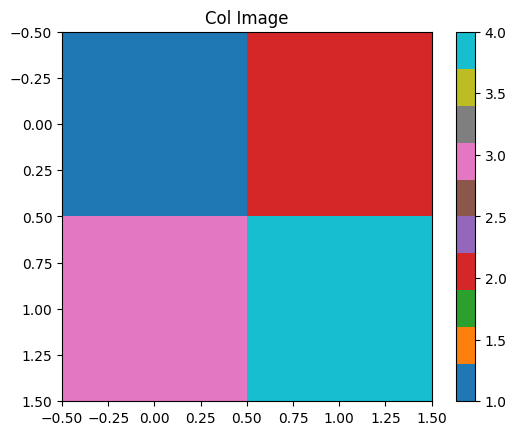

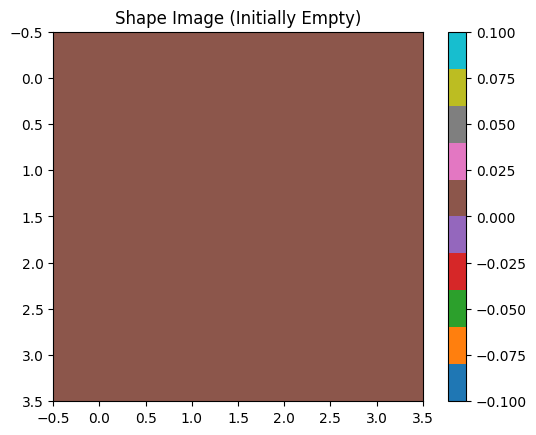

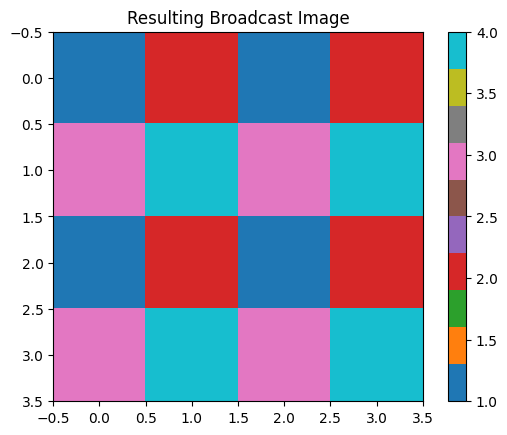

In [36]:
import matplotlib.pyplot as plt

class Image:
    def __init__(self, x=0, y=0, w=0, h=0, mask=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if mask is None:
            self.mask = np.zeros((h, w), dtype=np.int8)
        else:
            self.mask = np.array(mask, dtype=np.int8).reshape(h, w)

    def __getitem__(self, idx):
        i, j = idx
        return self.mask[i, j]

    def __setitem__(self, idx, value):
        i, j = idx
        self.mask[i, j] = value

    @staticmethod
    def broadcast(col: 'Image', shape: 'Image', include0: int = 1) -> 'Image':
        if col.w * col.h == 0 or shape.w * shape.h == 0:
            return Image()  # badImg equivalent

        ret = Image(shape.x, shape.y, shape.w, shape.h)
        
        for i in range(shape.h):
            for j in range(shape.w):
                ret[i, j] = col[i % col.h, j % col.w]

        return ret

def visualize_image(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage
col = Image(0, 0, 2, 2, [[1, 2], [3, 4]])
shape = Image(0, 0, 4, 4)
result = Image.broadcast(col, shape)

# Visualize the images
visualize_image(col, "Col Image")
visualize_image(shape, "Shape Image (Initially Empty)")
visualize_image(result, "Resulting Broadcast Image")


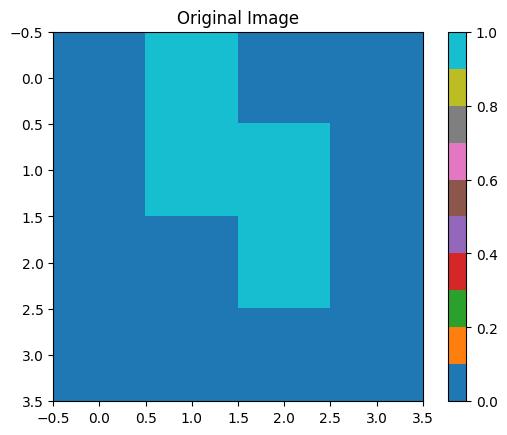

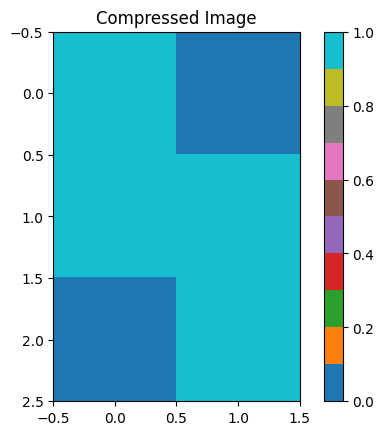

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])

class Image:
    def __init__(self, x=0, y=0, w=0, h=0, mask=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if mask is None:
            self.mask = np.zeros((h, w), dtype=np.int8)
        else:
            self.mask = np.array(mask, dtype=np.int8).reshape(h, w)

    def __getitem__(self, idx):
        i, j = idx
        return self.mask[i, j]

    def __setitem__(self, idx, value):
        i, j = idx
        self.mask[i, j] = value

    @staticmethod
    def full(p: Point, sz: Point, filling: int = 1) -> 'Image':
        img = Image(p.x, p.y, sz.x, sz.y)
        img.mask.fill(filling)
        return img

    @staticmethod
    def empty(x: int, y: int, w: int, h: int) -> 'Image':
        return Image(x, y, w, h, np.zeros((h, w), dtype=np.int8))

    def copy(self) -> 'Image':
        return Image(self.x, self.y, self.w, self.h, self.mask.copy())

    def col_mask(self) -> int:
        mask = 0
        for i in range(self.h):
            for j in range(self.w):
                mask |= 1 << self[i, j]
        return mask

    def majority_col(self) -> int:
        counts = np.bincount(self.mask.flatten(), minlength=10)
        return np.argmax(counts)

def compress(img: Image, bg: Image = None) -> Image:
    if bg is None:
        bg = Image.full(Point(0, 0), Point(1, 1), 0)  # Use a full image with 0 as background

    bg_mask = bg.col_mask()

    xmi, xma, ymi, yma = img.w, -1, img.h, -1
    for i in range(img.h):
        for j in range(img.w):
            if not (bg_mask & (1 << img[i, j])) and img[i, j] != 0:
                xmi, xma = min(xmi, j), max(xma, j)
                ymi, yma = min(ymi, i), max(yma, i)

    if xmi > xma or ymi > yma:
        return Image(0, 0, 0, 0)

    ret = Image(img.x + xmi, img.y + ymi, xma - xmi + 1, yma - ymi + 1)
    for i in range(ymi, yma + 1):
        for j in range(xmi, xma + 1):
            ret[i - ymi, j - xmi] = img[i, j]
    return ret

def visualize_image(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage and visualization
img = Image(1, 1, 4, 4, [[0, 1, 0, 0], [0, 1, 1, 0], [0, 0, 1, 0], [0, 0, 0, 0]])
compressed = compress(img)

# Visualize the images
visualize_image(img, "Original Image")
visualize_image(compressed, "Compressed Image")


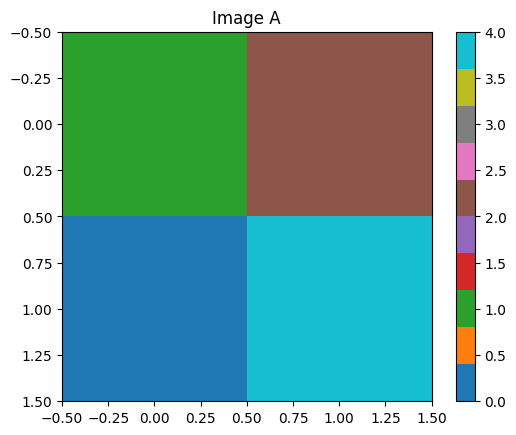

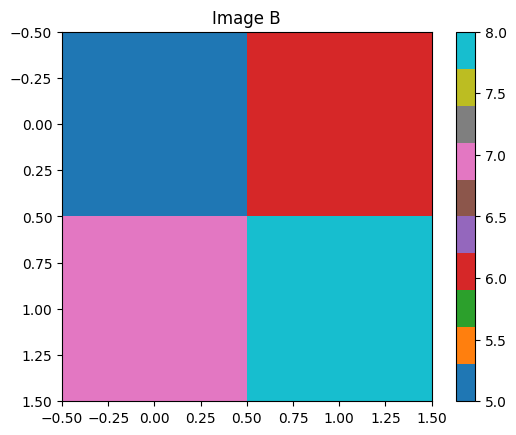

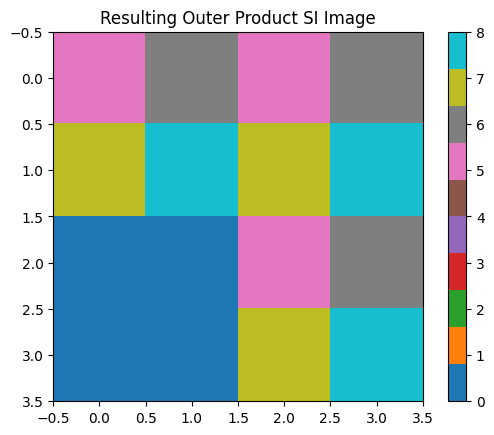

In [38]:
def outer_product_si(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret = Image.empty(0, 0, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = (a[i, j] > 0) * b[k, l]
    return ret

def visualize_image(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage and visualization
a = Image(0, 0, 2, 2, [[1, 2], [0, 4]])
b = Image(0, 0, 2, 2, [[5, 6], [7, 8]])
result = outer_product_si(a, b)

# Visualize the images
visualize_image(a, "Image A")
visualize_image(b, "Image B")
visualize_image(result, "Resulting Outer Product SI Image")


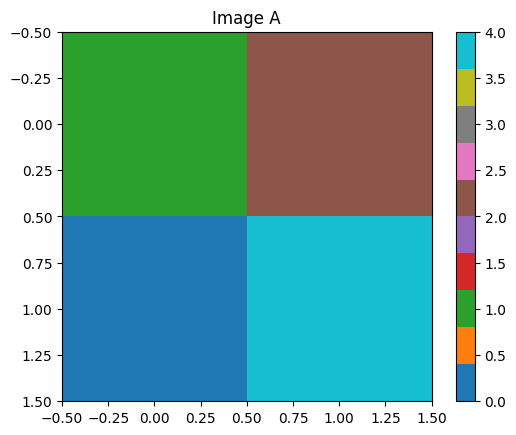

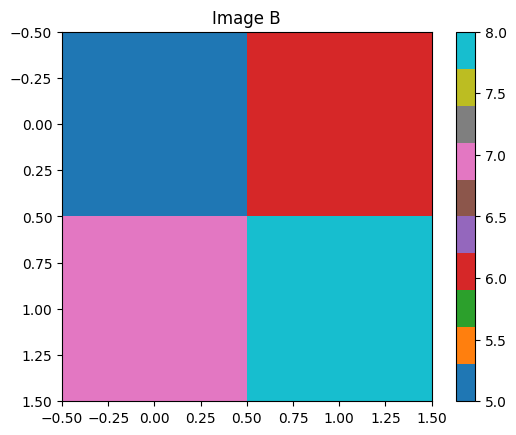

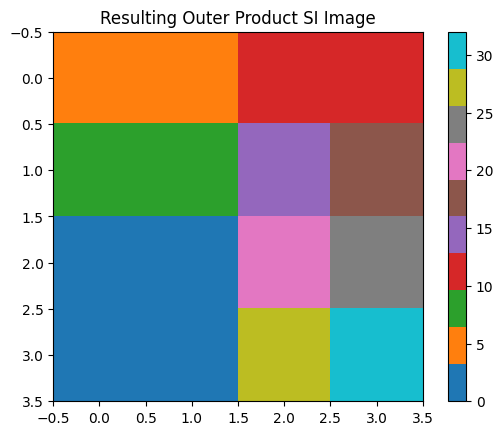

In [39]:
def outer_product_si(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret = Image.empty(0, 0, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = (a[i, j] if a[i, j] > 0 else 0) * b[k, l]
    return ret

def visualize_image(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage and visualization
a = Image(0, 0, 2, 2, [[1, 2], [0, 4]])
b = Image(0, 0, 2, 2, [[5, 6], [7, 8]])
result = outer_product_si(a, b)

# Visualize the images
visualize_image(a, "Image A")
visualize_image(b, "Image B")
visualize_image(result, "Resulting Outer Product SI Image")


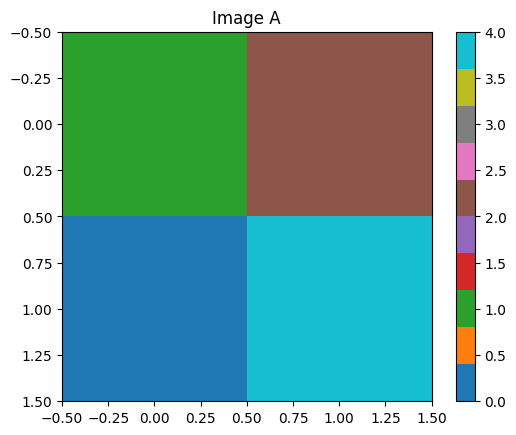

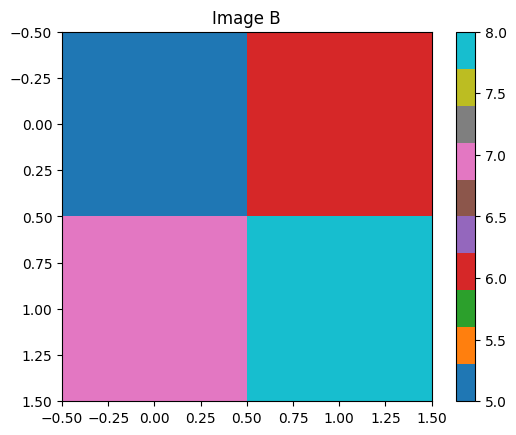

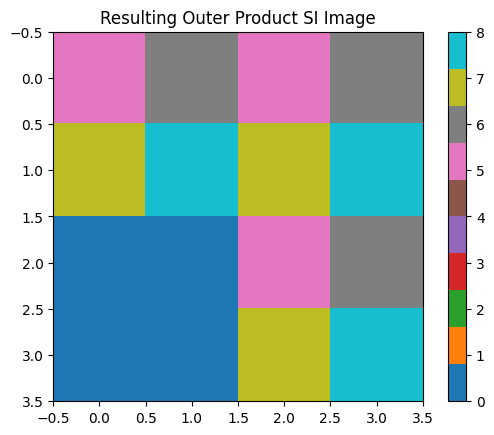

In [40]:
def outer_product_si(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret = Image.empty(0, 0, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = (a[i, j] > 0) * b[k, l]
    return ret

def visualize_image(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage and visualization
a = Image(0, 0, 2, 2, [[1, 2], [0, 4]])
b = Image(0, 0, 2, 2, [[5, 6], [7, 8]])
result = outer_product_si(a, b)

# Visualize the images
visualize_image(a, "Image A")
visualize_image(b, "Image B")
visualize_image(result, "Resulting Outer Product SI Image")


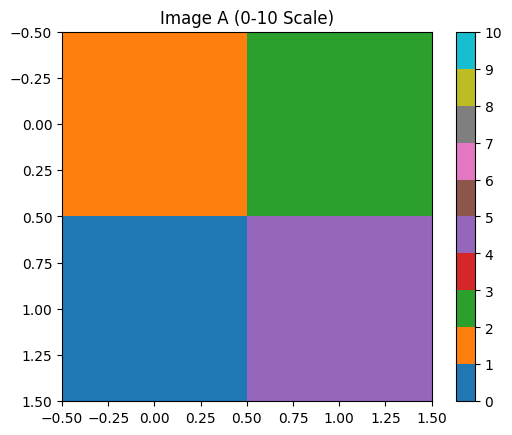

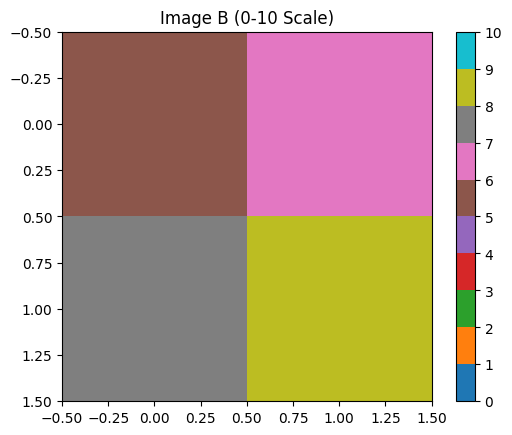

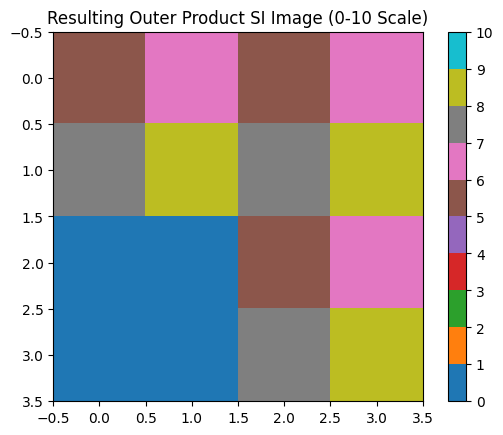

In [41]:
def visualize_image_scaled(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10', vmin=0, vmax=10)
    plt.colorbar(ticks=range(11))
    plt.title(title)
    plt.show()

# Example usage and visualization
a = Image(0, 0, 2, 2, [[1, 2], [0, 4]])
b = Image(0, 0, 2, 2, [[5, 6], [7, 8]])
result = outer_product_si(a, b)

# Visualize the images with a scale of 0-10
visualize_image_scaled(a, "Image A (0-10 Scale)")
visualize_image_scaled(b, "Image B (0-10 Scale)")
visualize_image_scaled(result, "Resulting Outer Product SI Image (0-10 Scale)")


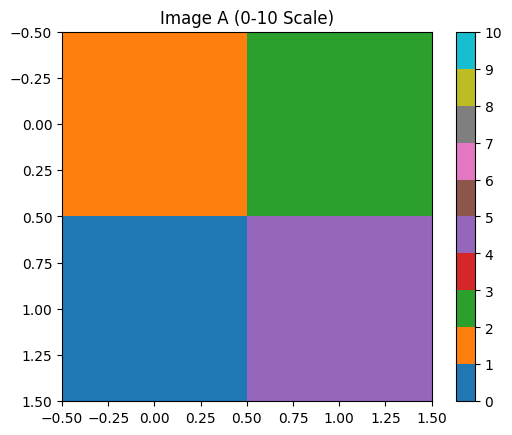

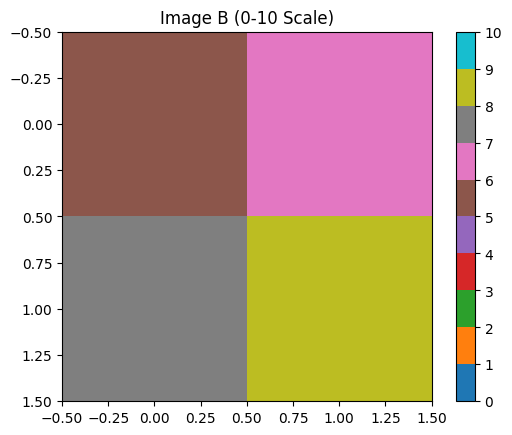

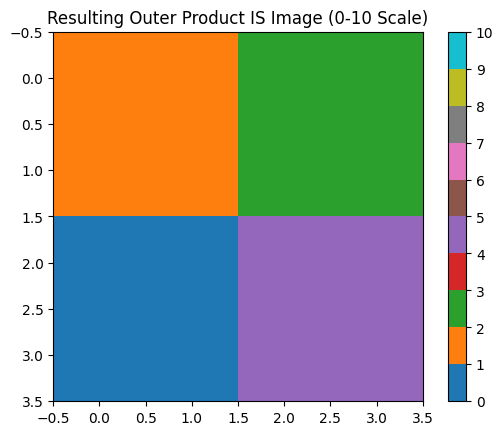

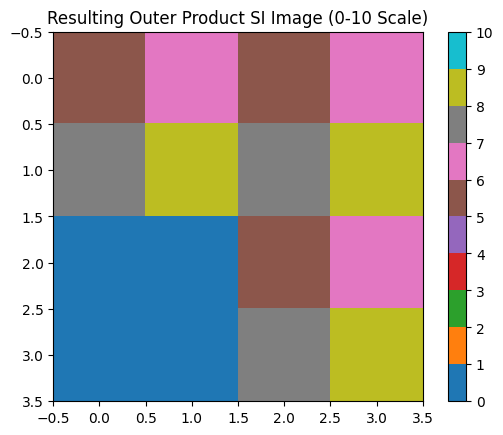

In [42]:
def outer_product_is(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret = Image.empty(0, 0, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = a[i, j] * (1 if b[k, l] != 0 else 0)
    return ret

def outer_product_si(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret = Image.empty(0, 0, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = (1 if a[i, j] > 0 else 0) * b[k, l]
    return ret

def visualize_image_scaled(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10', vmin=0, vmax=10)
    plt.colorbar(ticks=range(11))
    plt.title(title)
    plt.show()

# Example usage and visualization
a = Image(0, 0, 2, 2, [[1, 2], [0, 4]])
b = Image(0, 0, 2, 2, [[5, 6], [7, 8]])
result_is = outer_product_is(a, b)
result_si = outer_product_si(a, b)

# Visualize the images with a scale of 0-10
visualize_image_scaled(a, "Image A (0-10 Scale)")
visualize_image_scaled(b, "Image B (0-10 Scale)")
visualize_image_scaled(result_is, "Resulting Outer Product IS Image (0-10 Scale)")
visualize_image_scaled(result_si, "Resulting Outer Product SI Image (0-10 Scale)")


In [113]:
import numpy as np
from collections import namedtuple
# from arclang.image import Image, Point
from typing import List, Tuple, Callable

def col(id: int) -> Image:
    assert 0 <= id < 10
    return Image.full(Point(0, 0), Point(1, 1), id)

def pos(dx: int, dy: int) -> Image:
    return Image.full(Point(dx, dy), Point(1, 1))

def square(id: int) -> Image:
    assert id >= 1
    return Image.full(Point(0, 0), Point(id, id))

def line(orient: int, id: int) -> Image:
    assert id >= 1
    w, h = (id, 1) if orient == 0 else (1, id)
    return Image.full(Point(0, 0), Point(w, h))

def get_pos(img: Image) -> Image:
    return Image.full(Point(img.x, img.y), Point(1, 1), img.majority_col())

def get_size(img: Image) -> Image:
    return Image.full(Point(0, 0), Point(img.w, img.h), img.majority_col())

def hull(img: Image) -> Image:
    return Image.full(Point(img.x, img.y), Point(img.w, img.h), img.majority_col())

def to_origin(img: Image) -> Image:
    img.x, img.y = 0, 0
    return img

def get_w(img: Image, id: int) -> Image:
    return Image.full(Point(0, 0), Point(img.w, img.w if id else 1), img.majority_col())

def get_h(img: Image, id: int) -> Image:
    return Image.full(Point(0, 0), Point(img.h if id else 1, img.h), img.majority_col())

def hull0(img: Image) -> Image:
    return Image.full(Point(img.x, img.y), Point(img.w, img.h), 0)

def get_size0(img: Image) -> Image:
    return Image.full(Point(0, 0), Point(img.w, img.h), 0)

def move(img: Image, p: Image) -> Image:
    img.x += p.x
    img.y += p.y
    return img

def filter_col(img: Image, palette: Image) -> Image:
    ret = img.copy()
    pal_mask = palette.col_mask()
    for i in range(img.h):
        for j in range(img.w):
            if not (pal_mask & (1 << img[i, j])):
                ret[i, j] = 0
    return ret

def filter_col_id(img: Image, id: int) -> Image:
    assert 0 <= id < 10
    if id == 0:
        return invert(img)
    else:
        return filter_col(img, col(id))


def broadcast(col: 'Image', shape: 'Image', include0: int = 1) -> 'Image':
    if col.w * col.h == 0 or shape.w * shape.h == 0:
        return Image()  # badImg equivalent

    ret = Image(shape.x, shape.y, shape.w, shape.h)
    
    for i in range(shape.h):
        for j in range(shape.w):
            ret[i, j] = col[i % col.h, j % col.w]

    return ret

def col_shape(col: Image, shape: Image) -> Image:
    if shape.w * shape.h == 0 or col.w * col.h == 0:
        return Image()  # bad image
    ret = broadcast(col, get_size(shape))
    ret.x, ret.y = shape.x, shape.y
    for i in range(ret.h):
        for j in range(ret.w):
            if not shape[i, j]:
                ret[i, j] = 0
    return ret

def col_shape_id(shape: Image, id: int) -> Image:
    assert 0 <= id < 10
    ret = shape.copy()
    ret.mask = np.where(ret.mask != 0, id, 0)
    return ret

def compress(img: Image, bg: Image = None) -> Image:
    if bg is None:
        bg = Image.full(Point(0, 0), Point(1, 1), 0)  # Use a full image with 0 as background

    bg_mask = bg.col_mask()

    xmi, xma, ymi, yma = img.w, -1, img.h, -1
    for i in range(img.h):
        for j in range(img.w):
            if not (bg_mask & (1 << img[i, j])) and img[i, j] != 0:
                xmi, xma = min(xmi, j), max(xma, j)
                ymi, yma = min(ymi, i), max(yma, i)

    if xmi > xma or ymi > yma:
        return Image(0, 0, 0, 0)

    ret = Image(img.x + xmi, img.y + ymi, xma - xmi + 1, yma - ymi + 1)
    for i in range(ymi, yma + 1):
        for j in range(xmi, xma + 1):
            ret[i - ymi, j - xmi] = img[i, j]
    return ret

def embed(img: Image, shape: Image) -> Image:
    ret = Image(shape.x, shape.y, shape.w, shape.h)
    dx, dy = shape.x - img.x, shape.y - img.y
    sx, sy = max(0, -dx), max(0, -dy)
    ex, ey = min(ret.w, img.w - dx), min(ret.h, img.h - dy)

    ret_mask = ret.mask.reshape(ret.h, ret.w)
    img_mask = img.mask.reshape(img.h, img.w)
    ret_mask[sy:ey, sx:ex] = img_mask[sy+dy:ey+dy, sx+dx:ex+dx]
    return ret

def compose(a: Image, b: Image, f: Callable[[int, int], int], overlap_only: int) -> Image:
    if overlap_only == 1:
        ret_x = max(a.x, b.x)
        ret_y = max(a.y, b.y)
        ra_x, ra_y = a.x + a.w, a.y + a.h
        rb_x, rb_y = b.x + b.w, b.y + b.h
        ret_w = min(ra_x, rb_x) - ret_x
        ret_h = min(ra_y, rb_y) - ret_y
        if ret_w <= 0 or ret_h <= 0:
            return Image()  # bad image
    elif overlap_only == 0:
        ret_x = min(a.x, b.x)
        ret_y = min(a.y, b.y)
        ra_x, ra_y = a.x + a.w, a.y + a.h
        rb_x, rb_y = b.x + b.w, b.y + b.h
        ret_w = max(ra_x, rb_x) - ret_x
        ret_h = max(ra_y, rb_y) - ret_y
    elif overlap_only == 2:
        ret_x, ret_y = a.x, a.y
        ret_w, ret_h = a.w, a.h
    else:
        assert False

    if ret_w > 100 or ret_h > 100 or ret_w * ret_h > 1600:
        return Image()  # bad image

    ret = Image(ret_x, ret_y, ret_w, ret_h)
    da_x, da_y = ret_x - a.x, ret_y - a.y
    db_x, db_y = ret_x - b.x, ret_y - b.y

    for i in range(ret_h):
        for j in range(ret_w):
            ca = a.safe(i + da_y, j + da_x)
            cb = b.safe(i + db_y, j + db_x)
            ret[i, j] = f(ca, cb)

    return ret

def compose_id(a: Image, b: Image, id: int = 0) -> Image:
    if id == 0:
        return compose(a, b, lambda x, y: y if y else x, 0)
    elif id == 1:
        return compose(a, b, lambda x, y: y if y else x, 1)
    elif id == 2:
        return compose(a, b, lambda x, y: x if y else 0, 1)
    elif id == 3:
        return compose(a, b, lambda x, y: y if y else x, 2)
    elif id == 4:
        return compose(a, b, lambda x, y: 0 if y else x, 2)
    else:
        assert 0 <= id < 5
        return Image()  # bad image

def outer_product_is(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret_x = a.x * b.w + b.x
    ret_y = a.y * b.h + b.y
    ret = Image.empty(ret_x, ret_y, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = a[i, j] * (1 if b[k, l] else 0)
    return ret

def outer_product_si(a: Image, b: Image) -> Image:
    if a.w * b.w > 100 or a.h * b.h > 100 or a.w * b.w * a.h * b.h > 1600:
        return Image()  # bad image
    ret_x = a.x * b.w + b.x
    ret_y = a.y * b.h + b.y
    ret = Image.empty(ret_x, ret_y, a.w * b.w, a.h * b.h)
    for i in range(a.h):
        for j in range(a.w):
            for k in range(b.h):
                for l in range(b.w):
                    ret[i*b.h + k, j*b.w + l] = (1 if a[i, j] > 0 else 0) * b[k, l]
    return ret

def fill(a: Image) -> Image:
    # Create an image filled with the majority color of 'a'
    ret = Image.full(Point(a.x, a.y), Point(a.w, a.h), a.majority_col())
    q = []

    # Identify the border pixels and add them to the queue
    for i in range(a.h):
        for j in range(a.w):
            if (i == 0 or j == 0 or i == a.h-1 or j == a.w-1) and not a[i, j]:
                q.append((i, j))
                ret[i, j] = 0
    
    # Perform BFS to fill the area
    while q:
        r, c = q.pop(0)
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < a.h and 0 <= nc < a.w and not a[nr, nc] and ret[nr, nc] != 0:
                q.append((nr, nc))
                ret[nr, nc] = 0
    return ret

def interior(a: Image) -> Image:
    return compose(fill(a), a, lambda x, y: 0 if y else x, 0)

def border(a: Image) -> Image:
    ret = Image(a.x, a.y, a.w, a.h)
    q = []
    for i in range(a.h):
        for j in range(a.w):
            if i == 0 or j == 0 or i == a.h-1 or j == a.w-1:
                if not a[i, j]:
                    q.append((i, j))
                ret[i, j] = 1
    
    while q:
        r, c = q.pop()
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                nr, nc = r + dr, c + dc
                if 0 <= nr < a.h and 0 <= nc < a.w and not ret[nr, nc]:
                    ret[nr, nc] = 1
                    if not a[nr, nc]:
                        q.append((nr, nc))
    
    ret.mask = ret.mask * a.mask
    return ret

def align_x(a: Image, b: Image, id: int) -> Image:
    assert 0 <= id < 5
    ret = a.copy()
    if id == 0:
        ret.x = b.x - a.w
    elif id == 1:
        ret.x = b.x
    elif id == 2:
        ret.x = b.x + (b.w - a.w) // 2
    elif id == 3:
        ret.x = b.x + b.w - a.w
    elif id == 4:
        ret.x = b.x + b.w
    return ret

def align_y(a: Image, b: Image, id: int) -> Image:
    assert 0 <= id < 5
    ret = a.copy()
    if id == 0:
        ret.y = b.y - a.h
    elif id == 1:
        ret.y = b.y
    elif id == 2:
        ret.y = b.y + (b.h - a.h) // 2
    elif id == 3:
        ret.y = b.y + b.h - a.h
    elif id == 4:
        ret.y = b.y + b.h
    return ret

def align(a: Image, b: Image, idx: int, idy: int) -> Image:
    assert 0 <= idx < 6 and 0 <= idy < 6
    ret = a.copy()
    if idx == 0:
        ret.x = b.x - a.w
    elif idx == 1:
        ret.x = b.x
    elif idx == 2:
        ret.x = b.x + (b.w - a.w) // 2
    elif idx == 3:
        ret.x = b.x + b.w - a.w
    elif idx == 4:
        ret.x = b.x + b.w

    if idy == 0:
        ret.y = b.y - a.h
    elif idy == 1:
        ret.y = b.y
    elif idy == 2:
        ret.y = b.y + (b.h - a.h) // 2
    elif idy == 3:
        ret.y = b.y + b.h - a.h
    elif idy == 4:
        ret.y = b.y + b.h
    return ret

def align_images(a: Image, b: Image) -> Image:
    ret = a.copy()
    match_size = 0
    for c in range(1, 10):
        ca = compress(filter_col_id(a, c))
        cb = compress(filter_col_id(b, c))
        if ca.mask.tolist() == cb.mask.tolist():
            cnt = ca.count()
            if cnt > match_size:
                match_size = cnt
                ret.x = a.x + cb.x - ca.x
                ret.y = a.y + cb.y - ca.y
    if match_size == 0:
        return Image()  # bad image
    return ret

def replace_cols(base: Image, cols: Image) -> Image:
    ret = base.copy()
    done = Image.empty(base.x, base.y, base.w, base.h)
    dx, dy = base.x - cols.x, base.y - cols.y

    def dfs(r: int, c: int, acol: int) -> List[Tuple[int, int]]:
        if r < 0 or r >= base.h or c < 0 or c >= base.w or base[r, c] != acol or done[r, c]:
            return []
        path = [(r, c)]
        done[r, c] = 1
        for nr in [r-1, r, r+1]:
            for nc in [c-1, c, c+1]:
                path.extend(dfs(nr, nc, acol))
        return path

    for i in range(base.h):
        for j in range(base.w):
            if not done[i, j] and base[i, j]:
                acol = base[i, j]
                cnt = [0] * 10
                path = dfs(i, j, acol)
                for r, c in path:
                    cnt[cols.safe(r + dy, c + dx)] += 1
                maj = max(range(1, 10), key=lambda c: cnt[c])
                for r, c in path:
                    ret[r, c] = maj

    return ret

def center(img: Image) -> Image:
    sz_x = (img.w + 1) % 2 + 1
    sz_y = (img.h + 1) % 2 + 1
    return Image(img.x + (img.w - sz_x) // 2, img.y + (img.h - sz_y) // 2, sz_x, sz_y)

def transform(img: Image, A00: int, A01: int, A10: int, A11: int) -> Image:
    if img.w * img.h == 0:
        return img
    c = center(img)
    off_x = 1 - c.w + 2 * (img.x - c.x)
    off_y = 1 - c.h + 2 * (img.y - c.y)

    def t(p: Point) -> Point:
        x, y = 2 * p.x + off_x, 2 * p.y + off_y
        nx = A00 * x + A01 * y
        ny = A10 * x + A11 * y
        return Point((nx - off_x) // 2, (ny - off_y) // 2)

    corners = [t(Point(0, 0)), t(Point(img.w-1, 0)), t(Point(0, img.h-1)), t(Point(img.w-1, img.h-1))]
    a = Point(min(c.x for c in corners), min(c.y for c in corners))
    b = Point(max(c.x for c in corners), max(c.y for c in corners))
    
    ret = Image.empty(img.x, img.y, b.x - a.x + 1, b.y - a.y + 1)
    for i in range(img.h):
        for j in range(img.w):
            go = t(Point(j, i))
            go = Point(go.x - a.x, go.y - a.y)
            ret[go.y, go.x] = img[i, j]
    return ret

def mirror_heuristic(img: Image) -> bool:
    cnt = sumx = sumy = 0
    for i in range(img.h):
        for j in range(img.w):
            if img[i, j]:
                cnt += 1
                sumx += j
                sumy += i
    return abs(sumx * 2 - (img.w - 1) * cnt) < abs(sumy * 2 - (img.h - 1) * cnt)

def rigid(img: Image, id: int) -> Image:
    if id == 0:
        return img
    elif id == 1:
        return transform(img, 0, 1, -1, 0)  # CCW
    elif id == 2:
        return transform(img, -1, 0, 0, -1)  # 180
    elif id == 3:
        return transform(img, 0, -1, 1, 0)  # CW
    elif id == 4:
        return transform(img, -1, 0, 0, 1)  # flip x
    elif id == 5:
        return transform(img, 1, 0, 0, -1)  # flip y
    elif id == 6:
        return transform(img, 0, 1, 1, 0)  # swap xy
    elif id == 7:
        return transform(img, 0, -1, -1, 0)  # swap other diagonal
    elif id == 8:
        return rigid(img, 4 + int(mirror_heuristic(img)))
    else:
        assert 0 <= id < 9
        return Image()  # bad image
    

def invert(img: Image) -> Image:
    if img.w * img.h == 0:
        return img
    mask = img.col_mask()
    col = 1
    while col < 10 and not (mask & (1 << col)):
        col += 1
    if col == 10:
        col = 1

    ret = img.copy()
    ret.mask = np.where(ret.mask != 0, 0, col)
    return ret

def maj_col(img: Image) -> Image:
    return col(img.majority_col())


def interior2(a: Image) -> Image:
    return compose(a, invert(border(a)), 2)

def count(img: Image, id: int, out_type: int) -> Image:
    assert 0 <= id < 7 and 0 <= out_type < 3
    if id == 0: num = img.count()
    elif id == 1: num = img.count_cols()
    elif id == 2: num = img.count_components()
    elif id == 3: num = img.w
    elif id == 4: num = img.h
    elif id == 5: num = max(img.w, img.h)
    elif id == 6: num = min(img.w, img.h)
    
    sz = Point(num, num) if out_type == 0 else Point(num, 1) if out_type == 1 else Point(1, num)
    
    if max(sz.x, sz.y) > 100 or sz.x * sz.y > 1600:
        return Image()  # bad image
    return Image.full(Point(0, 0), sz, img.majority_col())

def wrap(line: Image, area: Image) -> Image:
    if line.w * line.h == 0 or area.w * area.h == 0:
        return Image()  # bad image
    ans = Image.empty(Point(0, 0), Point(area.w, area.h))
    for i in range(line.h):
        for j in range(line.w):
            x, y = j, i
            x += y // area.h * line.w
            y %= area.h
            y += x // area.w * line.h
            x %= area.w
            if 0 <= x < ans.w and 0 <= y < ans.h:
                ans[y, x] = line[i, j]
    return ans

def smear(base: Image, room: Image, id: int) -> Image:
    assert 0 <= id < 7
    mask = [1, 2, 4, 8, 3, 12, 15][id]
    d = Point(room.x - base.x, room.y - base.y)
    ret = embed(base, hull(room))
    
    def smear_direction(range_i, range_j, condition):
        for i in range_i:
            c = 0
            for j in range_j:
                if not room[i, j]: c = 0
                elif base.safe(i + d.y, j + d.x): c = base[i + d.y, j + d.x]
                if c and condition(i, j): ret[i, j] = c

    if mask & 1: smear_direction(range(ret.h), range(ret.w), lambda i, j: True)
    if mask & 2: smear_direction(range(ret.h), range(ret.w - 1, -1, -1), lambda i, j: True)
    if mask & 4: smear_direction(range(ret.w), range(ret.h), lambda i, j: True)
    if mask & 8: smear_direction(range(ret.w), range(ret.h - 1, -1, -1), lambda i, j: True)
    
    return ret

def extend(img: Image, room: Image) -> Image:
    if img.w * img.h == 0:
        return Image()  # bad image
    ret = room.copy()
    for i in range(ret.h):
        for j in range(ret.w):
            p = Point(j, i) + Point(room.x - img.x, room.y - img.y)
            p.x = max(0, min(p.x, img.w - 1))
            p.y = max(0, min(p.y, img.h - 1))
            ret[i, j] = img[p.y, p.x]
    return ret

def pick_max(v: List[Image], f: Callable[[Image], int]) -> Image:
    if not v:
        return Image()  # bad image
    return max(v, key=f)

def max_criterion(img: Image, id: int) -> int:
    assert 0 <= id < 14
    if id == 0: return img.count()
    elif id == 1: return -img.count()
    elif id == 2: return img.w * img.h
    elif id == 3: return -img.w * img.h
    elif id == 4: return img.count_cols()
    elif id == 5: return -img.y
    elif id == 6: return img.y
    elif id == 7: return img.count_components()
    elif id in (8, 9):
        comp = compress(img)
        return (comp.w * comp.h - comp.count()) * (-1 if id == 9 else 1)
    elif id in (10, 11):
        return img.count_interior() * (-1 if id == 11 else 1)
    elif id == 12: return -img.x
    elif id == 13: return img.x

def cut(img: Image, a: Image) -> List[Image]:
    ret = []
    done = Image.empty(img.x, img.y, img.w, img.h)
    d = Point(img.x - a.x, img.y - a.y)
    
    def dfs(r: int, c: int, toadd: Image):
        if r < 0 or r >= img.h or c < 0 or c >= img.w or a.safe(r + d.y, c + d.x) or done[r, c]:
            return
        toadd[r, c] = img[r, c] + 1
        done[r, c] = 1
        for nr in (r-1, r, r+1):
            for nc in (c-1, c, c+1):
                dfs(nr, nc, toadd)

    for i in range(img.h):
        for j in range(img.w):
            if not done[i, j] and not a.safe(i + d.y, j + d.x):
                toadd = Image.empty(img.x, img.y, img.w, img.h)
                dfs(i, j, toadd)
                toadd = compress(toadd)
                toadd.mask = np.maximum(toadd.mask - 1, 0)
                ret.append(toadd)
    return ret

def split_cols(img: Image, include0: int = 0) -> List[Image]:
    ret = []
    mask = img.col_mask()
    for c in range(int(not include0), 10):
        if mask & (1 << c):
            s = img.copy()
            s.mask = np.where(s.mask == c, c, 0)
            ret.append(s)
    return ret

def get_regular(img: Image) -> Image:
    ret = img.copy()
    col = [1] * img.w
    row = [1] * img.h
    for i in range(img.h):
        for j in range(img.w):
            if img[i, j] != img[i, 0]: row[i] = 0
            if img[i, j] != img[0, j]: col[j] = 0
    
    def get_regular_1d(arr):
        for w in range(1, len(arr)):
            s = -1
            if len(arr) % (w + 1) == w: s = w
            elif len(arr) % (w + 1) == 1: s = 0
            if s != -1 and all(arr[i] == (i % (w + 1) == s) for i in range(len(arr))):
                return
        arr[:] = [0] * len(arr)

    get_regular_1d(col)
    get_regular_1d(row)
    
    for i in range(img.h):
        for j in range(img.w):
            ret[i, j] = row[i] or col[j]
    return ret

def cut_pick_max(a: Image, b: Image, id: int) -> Image:
    return pick_max(cut(a, b), lambda img: max_criterion(img, id))

def regular_cut_pick_max(a: Image, id: int) -> Image:
    b = get_regular(a)
    return cut_pick_max(a, b, id)

def split_pick_max(a: Image, id: int, include0: int = 0) -> Image:
    return pick_max(split_cols(a, include0), lambda img: max_criterion(img, id))

def cut_compose(a: Image, b: Image, id: int) -> Image:
    v = cut(a, b)
    return compose([to_origin(img) for img in v], id)

def regular_cut_compose(a: Image, id: int) -> Image:
    b = get_regular(a)
    return cut_compose(a, b, id)

def split_compose(a: Image, id: int, include0: int = 0) -> Image:
    v = split_cols(a, include0)
    return compose([to_origin(compress(img)) for img in v], id)

def cut_index(a: Image, b: Image, ind: int) -> Image:
    v = cut(a, b)
    return v[ind] if 0 <= ind < len(v) else Image()

def pick_maxes(v: List[Image], f: Callable[[Image], int], invert: int = 0) -> List[Image]:
    if not v:
        return []
    scores = [f(img) for img in v]
    max_score = max(scores)
    return [img for img, score in zip(v, scores) if (score == max_score) ^ invert]

def pick_not_maxes(v: List[Image], id: int) -> List[Image]:
    return pick_maxes(v, lambda img: max_criterion(img, id), 1)

def cut_pick_maxes(a: Image, b: Image, id: int) -> Image:
    return compose(pick_maxes(cut(a, b), lambda img: max_criterion(img, id)), 0)

def split_pick_maxes(a: Image, id: int) -> Image:
    return compose(pick_maxes(split_cols(a), lambda img: max_criterion(img, id)), 0)

def heuristic_cut(img: Image) -> Image:
    ret = img.majority_col(include0=1)
    ret_score = -1
    mask = img.col_mask()
    done = Image.empty(img.x, img.y, img.w, img.h)
    
    def edgy(r: int, c: int, col: int):
        if r < 0 or r >= img.h or c < 0 or c >= img.w or img[r, c] != col or done[r, c]:
            return
        done[r, c] = 1
        for nr in (r-1, r, r+1):
            for nc in (c-1, c, c+1):
                edgy(nr, nc, col)

    for col in range(10):
        if not (mask & (1 << col)):
            continue
        done.mask.fill(0)
        top = bot = left = right = False
        for i in range(img.h):
            for j in range(img.w):
                if img[i, j] == col:
                    if i == 0: top = True
                    if j == 0: left = True
                    if i == img.h - 1: bot = True
                    if j == img.w - 1: right = True
                if (i in (0, img.h - 1) or j in (0, img.w - 1)) and img[i, j] == col and not done[i, j]:
                    edgy(i, j, col)
        
        if not ((top and bot) or (left and right)):
            continue

        score = float('inf')
        components = 0
        no_contained = True
        for i in range(img.h):
            for j in range(img.w):
                if not done[i, j] and img[i, j] != col:
                    cnt = 0
                    contained = True
                    stack = [(i, j)]
                    while stack:
                        r, c = stack.pop()
                        if r < 0 or r >= img.h or c < 0 or c >= img.w:
                            continue
                        if img[r, c] == col:
                            if done[r, c]:
                                contained = False
                            continue
                        if done[r, c]:
                            continue
                        cnt += 1
                        done[r, c] = 1
                        stack.extend([(r-1, c), (r+1, c), (r, c-1), (r, c+1)])
                    components += 1
                    score = min(score, cnt)
                    if contained:
                        no_contained = False
        if components >= 2 and no_contained and score > ret_score:
            ret_score = score
            ret = col
    return filter_col_id(img, ret)


def interior2(a: Image) -> Image:
    return compose(a, invert(border(a)), 2)

def count(img: Image, id: int, out_type: int) -> Image:
    assert 0 <= id < 7
    assert 0 <= out_type < 3
    if id == 0:
        num = img.count()
    elif id == 1:
        num = img.count_cols()
    elif id == 2:
        num = img.count_components()
    elif id == 3:
        num = img.w
    elif id == 4:
        num = img.h
    elif id == 5:
        num = max(img.w, img.h)
    elif id == 6:
        num = min(img.w, img.h)
    
    if out_type == 0:
        sz = Point(num, num)
    elif out_type == 1:
        sz = Point(num, 1)
    elif out_type == 2:
        sz = Point(1, num)
    
    if max(sz.x, sz.y) > 100 or sz.x * sz.y > 1600:
        return Image()  # bad image
    return Image.full(Point(0, 0), sz, img.majority_col())



def my_stack(a: Image, b: Image, orient: int) -> Image:
    assert 0 <= orient <= 3
    b.x, b.y = a.x, a.y
    if orient == 0:  # Horizontal
        b.x += a.w
    elif orient == 1:  # Vertical
        b.y += a.h
    elif orient == 2:  # Diagonal
        b.x += a.w
        b.y += a.h
    else:  # Other diagonal, bottom-left / top-right
        c = a.copy()
        c.y += b.h
        b.x += a.w
        return compose(c, b, 0)
    return compose(a, b, 0)


def wrap(line: Image, area: Image) -> Image:
    if line.w * line.h == 0 or area.w * area.h == 0:
        return Image()  # bad image
    ans = Image.empty(Point(0, 0), Point(area.w, area.h))
    for i in range(line.h):
        for j in range(line.w):
            x, y = j, i
            x += y // area.h * line.w
            y %= area.h
            y += x // area.w * line.h
            x %= area.w
            if 0 <= x < ans.w and 0 <= y < ans.h:
                ans[y, x] = line[i, j]
    return ans

def repeat(a: Image, b: Image, pad: int = 0) -> Image:
    if a.w * a.h <= 0 or b.w * b.h <= 0:
        return Image()  # bad image
    ret = Image.empty(b.x, b.y, b.w, b.h)
    W, H = a.w + pad, a.h + pad
    ai = ((b.y - a.y) % H + H) % H
    aj0 = ((b.x - a.x) % W + W) % W
    for i in range(ret.h):
        aj = aj0
        for j in range(ret.w):
            if ai < a.h and aj < a.w:
                ret[i, j] = a[ai, aj]
            aj = (aj + 1) % W
        ai = (ai + 1) % H
    return ret

def mirror(a: Image, b: Image, pad: int = 0) -> Image:
    if a.w * a.h <= 0 or b.w * b.h <= 0:
        return Image()  # bad image
    ret = Image.empty(b.x, b.y, b.w, b.h)
    W, H = a.w + pad, a.h + pad
    W2, H2 = W * 2, H * 2
    ai = ((b.y - a.y) % H2 + H2) % H2
    aj0 = ((b.x - a.x) % W2 + W2) % W2
    for i in range(ret.h):
        aj = aj0
        for j in range(ret.w):
            x, y = -1, -1
            if aj < a.w:
                x = aj
            elif W <= aj < W + a.w:
                x = W + a.w - 1 - aj
            if ai < a.h:
                y = ai
            elif H <= ai < H + a.h:
                y = H + a.h - 1 - ai
            if x != -1 and y != -1:
                ret[i, j] = a[y, x]
            aj = (aj + 1) % W2
        ai = (ai + 1) % H2
    return ret

In [114]:
img = Image(1, 1, 5, 5)
result = center(img)

In [115]:

def visualize_image_scaled(image: Image, title: str):
    plt.imshow(image.mask, cmap='tab10', vmin=0, vmax=10)
    plt.colorbar(ticks=range(11))
    plt.title(title)
    plt.show()


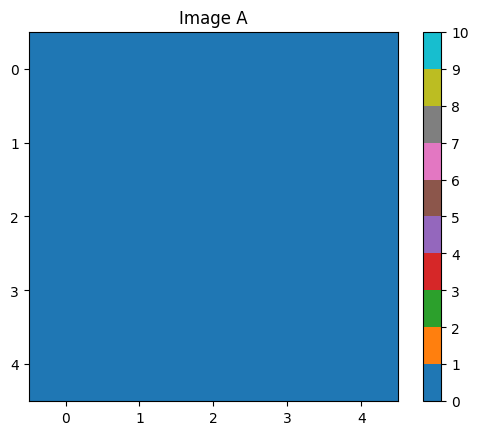

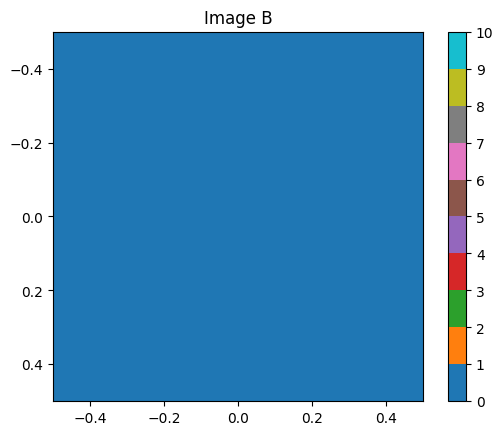

In [116]:
visualize_image_scaled(img, "Image A")
visualize_image_scaled(result, "Image B")

In [117]:
def center(img: Image) -> Image:
    sz_x = (img.w + 1) % 2 + 1
    sz_y = (img.h + 1) % 2 + 1
    center_x = img.x + (img.w - sz_x) // 2
    center_y = img.y + (img.h - sz_y) // 2
    return Image.full(Point(center_x, center_y), Point(sz_x, sz_y), img.majority_col())


In [118]:
img = Image(0, 0, 5, 5, [
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 2, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])

result = center(img)

# The center should be a 1x1 image containing the center pixel


# Test with an even-sized image
img_even = Image(1, 1, 4, 4, [
    [1, 1, 2, 2],
    [1, 1, 2, 2],
    [3, 3, 4, 4],
    [3, 3, 4, 4]
])

result_even = center(img_even)


In [119]:
result_even.mask

array([[1, 1],
       [1, 1]], dtype=int8)

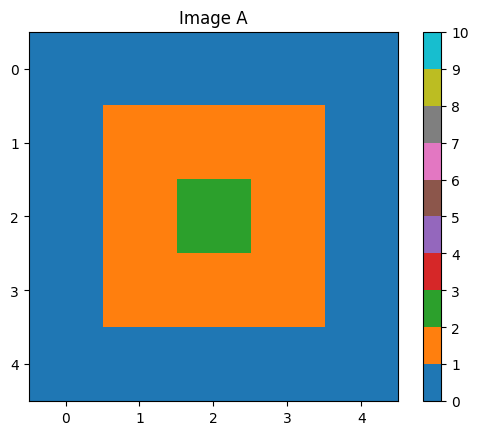

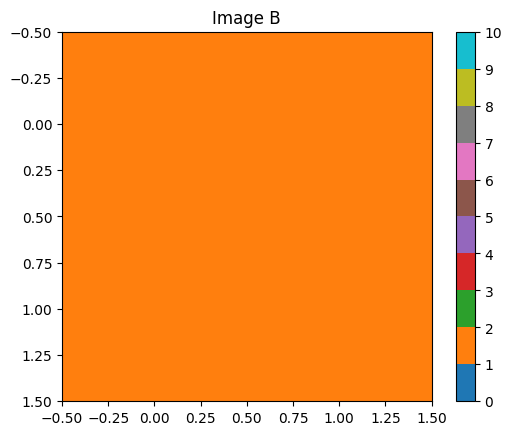

In [120]:
visualize_image_scaled(img, "Image A")
visualize_image_scaled(result_even, "Image B")

In [121]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_center(original: Image, centered: Image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1.imshow(original.mask, cmap='viridis')
    ax1.set_title(f"Original ({original.w}x{original.h})")
    ax1.axis('off')
    
    full_size = np.zeros((original.h, original.w))
    y_start, x_start = centered.y - original.y, centered.x - original.x
    full_size[y_start:y_start+centered.h, x_start:x_start+centered.w] = centered.mask
    
    ax2.imshow(full_size, cmap='viridis')
    ax2.set_title(f"Centered ({centered.w}x{centered.h})")
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def center(img: Image) -> Image:
    sz_x = (img.w + 1) % 2 + 1
    sz_y = (img.h + 1) % 2 + 1
    center_x = img.x + (img.w - sz_x) // 2
    center_y = img.y + (img.h - sz_y) // 2
    
    center_img = Image(center_x, center_y, sz_x, sz_y)
    for i in range(sz_y):
        for j in range(sz_x):
            center_img[i, j] = img[center_y - img.y + i, center_x - img.x + j]
    
    return center_img
# Test cases
def test_center():
    test_cases = [
        Image(0, 0, 5, 5, np.random.randint(0, 5, (5, 5))),  # Odd x Odd
        Image(0, 0, 4, 4, np.random.randint(0, 5, (4, 4))),  # Even x Even
        Image(0, 0, 3, 4, np.random.randint(0, 5, (4, 3))),  # Odd x Even
        Image(0, 0, 4, 3, np.random.randint(0, 5, (3, 4))),  # Even x Odd
        Image(0, 0, 1, 1, [[2]]),  # 1x1
        Image(0, 0, 2, 1, [[1, 2]]),  # 2x1
        Image(0, 0, 1, 2, [[1], [2]])  # 1x2
    ]

    for i, img in enumerate(test_cases):
        centered = center(img)
        print(f"\nTest case {i+1}:")
        print(f"Original: {img.w}x{img.h}, Centered: {centered.w}x{centered.h}")
        print(f"Center position: ({centered.x}, {centered.y})")
        visualize_center(img, centered)

        # Assertions
        assert centered.w in (1, 2), f"Centered width should be 1 or 2, got {centered.w}"
        assert centered.h in (1, 2), f"Centered height should be 1 or 2, got {centered.h}"
        assert centered.x == img.x + (img.w - centered.w) // 2, "Incorrect x position"
        assert centered.y == img.y + (img.h - centered.h) // 2, "Incorrect y position"
        assert np.all(centered.mask == img.majority_col()), "Centered image should be filled with majority color"



In [122]:
def center(img: Image) -> Image:
    sz_x = (img.w + 1) % 2 + 1
    sz_y = (img.h + 1) % 2 + 1
    return Image(img.x + (img.w - sz_x) // 2, img.y + (img.h - sz_y) // 2, sz_x, sz_y)



Test case 1:
Original: 5x5, Centered: 1x1
Center position: (2, 2)


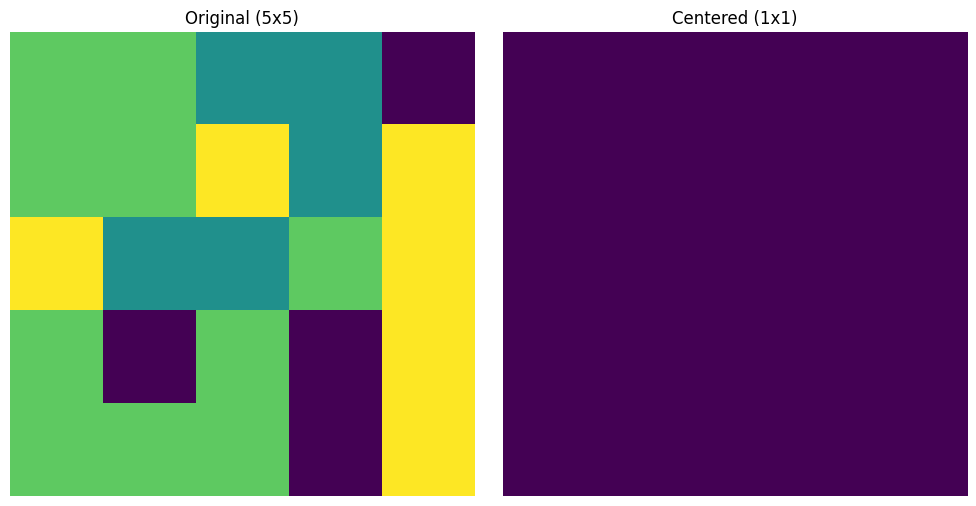

AssertionError: Centered image should be filled with majority color

In [123]:
test_cases = [
    Image(0, 0, 5, 5, np.random.randint(0, 5, (5, 5))),  # Odd x Odd
    Image(0, 0, 4, 4, np.random.randint(0, 5, (4, 4))),  # Even x Even
    Image(0, 0, 3, 4, np.random.randint(0, 5, (4, 3))),  # Odd x Even
    Image(0, 0, 4, 3, np.random.randint(0, 5, (3, 4))),  # Even x Odd
    Image(0, 0, 1, 1, [[2]]),  # 1x1
    Image(0, 0, 2, 1, [[1, 2]]),  # 2x1
    Image(0, 0, 1, 2, [[1], [2]])  # 1x2
]

for i, img in enumerate(test_cases):
    centered = center(img)
    print(f"\nTest case {i+1}:")
    print(f"Original: {img.w}x{img.h}, Centered: {centered.w}x{centered.h}")
    print(f"Center position: ({centered.x}, {centered.y})")
    visualize_center(img, centered)

    # Assertions
    assert centered.w in (1, 2), f"Centered width should be 1 or 2, got {centered.w}"
    assert centered.h in (1, 2), f"Centered height should be 1 or 2, got {centered.h}"
    assert centered.x == img.x + (img.w - centered.w) // 2, "Incorrect x position"
    assert centered.y == img.y + (img.h - centered.h) // 2, "Incorrect y position"
    assert np.all(centered.mask == img.majority_col()), "Centered image should be filled with majority color"


In [124]:
import unittest

In [125]:
class TestStringMethods(unittest.TestCase):
    def test_majority_col(self):
        # Test case 1: Normal case
        img1 = Image(0, 0, 3, 3, [[1, 2, 1], [2, 1, 2], [1, 2, 1]])
        self.assertEqual(img1.majority_col(), 1)
        
        # Test case 2: With zeros, include0=False (default)
        img2 = Image(0, 0, 3, 3, [[0, 1, 0], [1, 0, 1], [0, 1, 0]])
        self.assertEqual(img2.majority_col(), 1)
        
        # Test case 3: With zeros, include0=True
        self.assertEqual(img2.majority_col(include0=1), 0)
        
        # Test case 4: All zeros
        img3 = Image(0, 0, 2, 2, [[0, 0], [0, 0]])
        self.assertEqual(img3.majority_col(), 0)
        self.assertEqual(img3.majority_col(include0=1), 0)
        
        # Test case 5: Empty image
        img4 = Image(0, 0, 0, 0)
        self.assertEqual(img4.majority_col(), 0)

In [126]:
TestStringMethods().test_majority_col() 

In [127]:
test_majority_col()

TypeError: test_majority_col() missing 1 required positional argument: 'self'


Test case 1:
Original: 5x5, Centered: 1x1
Center position: (2, 2)


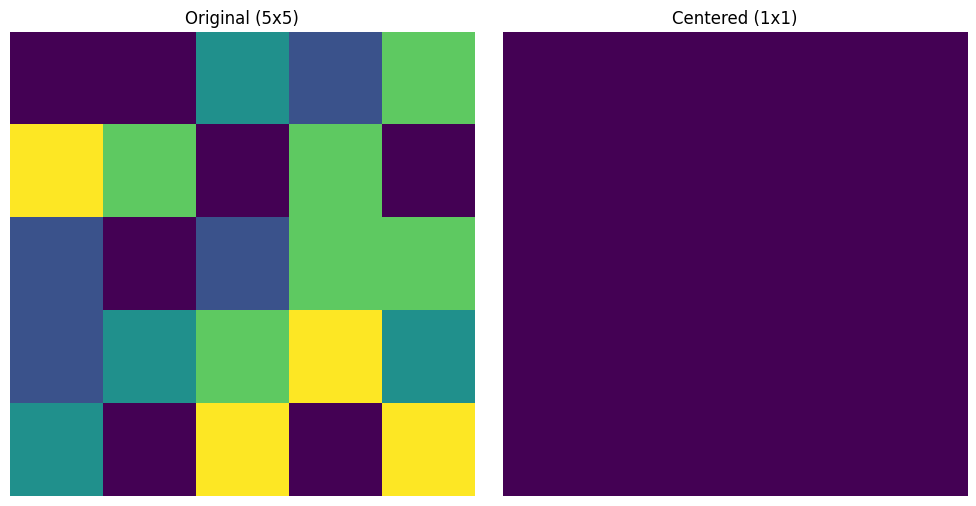

AssertionError: Centered image should be filled with majority color

In [128]:
test_center()

In [129]:
a = Image(0, 0, 2, 2, [[1, 2], [3, 4]])
b = Image(1, 1, 2, 2, [[5, 6], [7, 8]])
result = compose_id(a, b, 0)
expected = np.array([[1, 2, 0], [3, 5, 6], [0, 7, 8]])

In [130]:
result.mask

array([[1, 2, 0],
       [3, 5, 6],
       [0, 7, 8]], dtype=int8)

In [131]:
a.mask

array([[1, 2],
       [3, 4]], dtype=int8)

In [132]:

def compose(a: Union[Image, List[Image]], b: Union[Image, List[Image], None] = None, f: Callable[[int, int], int] = lambda x, y: y if y else x, overlap_only: int = 0) -> Image:
    if isinstance(a, list):
        return compose_list(a, f, overlap_only)
    if b is None:
        return a    
    if overlap_only == 1:
        ret_x = max(a.x, b.x)
        ret_y = max(a.y, b.y)
        ra_x, ra_y = a.x + a.w, a.y + a.h
        rb_x, rb_y = b.x + b.w, b.y + b.h
        ret_w = min(ra_x, rb_x) - ret_x
        ret_h = min(ra_y, rb_y) - ret_y
        if ret_w <= 0 or ret_h <= 0:
            return Image()  # bad image
    elif overlap_only == 0:
        ret_x = min(a.x, b.x)
        ret_y = min(a.y, b.y)
        ra_x, ra_y = a.x + a.w, a.y + a.h
        rb_x, rb_y = b.x + b.w, b.y + b.h
        ret_w = max(ra_x, rb_x) - ret_x
        ret_h = max(ra_y, rb_y) - ret_y
    elif overlap_only == 2:
        ret_x, ret_y = a.x, a.y
        ret_w, ret_h = a.w, a.h
    else:
        assert False

    if ret_w > 100 or ret_h > 100 or ret_w * ret_h > 1600:
        return Image()  # bad image

    ret = Image(ret_x, ret_y, ret_w, ret_h)
    da_x, da_y = ret_x - a.x, ret_y - a.y
    db_x, db_y = ret_x - b.x, ret_y - b.y

    for i in range(ret_h):
        for j in range(ret_w):
            ca = a.safe(i + da_y, j + da_x)
            cb = b.safe(i + db_y, j + db_x)
            ret[i, j] = f(ca, cb)

    return ret

def compose_list(imgs: List[Image], f: Callable[[int, int], int], overlap_only: int) -> Image:
    if not imgs:
        return Image()
    result = imgs[0]
    for img in imgs[1:]:
        result = compose(result, img, f, overlap_only)
    return result


In [133]:
imgs = [
    Image(0, 0, 2, 2, [[1, 0], [0, 0]]),
    Image(1, 1, 2, 2, [[0, 2], [0, 0]]),
    Image(1, 0, 2, 2, [[0, 0], [3, 0]])
]
result = compose(imgs)  
expected = np.array([
    [1, 0, 0],
    [0, 2, 2],
    [3, 3, 0]
])

In [134]:
def count(img: Image, id: int, out_type: int) -> Image:
    assert 0 <= id < 7 and 0 <= out_type < 3
    if id == 0: num = img.count()
    elif id == 1: num = img.count_cols()
    elif id == 2: num = img.count_components()
    elif id == 3: num = img.w
    elif id == 4: num = img.h
    elif id == 5: num = max(img.w, img.h)
    elif id == 6: num = min(img.w, img.h)
    
    sz = Point(num, num) if out_type == 0 else Point(num, 1) if out_type == 1 else Point(1, num)
    
    if max(sz.x, sz.y) > 100 or sz.x * sz.y > 1600:
        return Image()  # bad image
    return Image.full(Point(0, 0), sz, img.majority_col())


In [135]:
img = Image(0, 0, 3, 3, [[1, 2, 3], [0, 1, 2], [3, 0, 1]])
result = count(img, 0, 0)  # Count non-zero elements

In [136]:
img.majority_col()

1

In [137]:
img.mask

array([[1, 2, 3],
       [0, 1, 2],
       [3, 0, 1]], dtype=int8)

In [138]:
result.w

7

In [139]:
result.mask

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1]], dtype=int8)

In [107]:
import numpy as np
from functools import reduce
from collections import namedtuple
from typing import List, Tuple, Union

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

Point = namedtuple('Point', ['x', 'y'])

class Image:
    def __init__(self, x=0, y=0, w=0, h=0, mask=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        if mask is None:
            self.mask = np.zeros((h, w), dtype=np.int8)
        else:
            self.mask = np.array(mask, dtype=np.int8).reshape(h, w)

    def __getitem__(self, idx):
        i, j = idx
        return self.mask[i, j]

    def __setitem__(self, idx, value):
        i, j = idx
        self.mask[i, j] = value

    def safe(self, i, j):
        if i < 0 or j < 0 or i >= self.h or j >= self.w:
            return 0
        return self.mask[i, j]

    def __eq__(self, other):
        return np.array_equal(self.mask, other.mask) and self.x == other.x and self.y == other.y and self.w == other.w and self.h == other.h

    def __ne__(self, other):
        return not self.__eq__(other)

    def __lt__(self, other):
        if (self.w, self.h) != (other.w, other.h):
            return (self.w, self.h) < (other.w, other.h)
        return self.mask.flatten().tolist() < other.mask.flatten().tolist()
    
    def copy(self) -> 'Image':
        return Image(self.x, self.y, self.w, self.h, self.mask.copy())
    
    
    def col_mask(self) -> int:
        mask = 0
        for i in range(self.h):
            for j in range(self.w):
                mask |= 1 << self[i, j]
        return mask
    
    def count_cols(self, include0: int = 0) -> int:
        mask = self.col_mask()
        if not include0:
            mask &= ~1
        return bin(mask).count('1')
    
    def count(self) -> int:
        return np.sum(self.mask > 0)
    
    @staticmethod
    def full(p: Point, sz: Point, filling: int = 1) -> 'Image':
        img = Image(p.x, p.y, sz.x, sz.y)
        img.mask.fill(filling)
        return img
    
    @staticmethod
    def full_i(p: Point, sz: Point, filling: int = 1) -> 'Image':
        img = Image(p.x, p.y, sz.x, sz.y)
        img.mask.fill(filling)
        return img

    @staticmethod
    def empty_p(p: Point, sz: Point) -> 'Image':
        return Image.full(p, sz, 0)
    
    @staticmethod
    def empty(x: int, y: int, w: int, h: int) -> 'Image':
        return Image(x, y, w, h, np.zeros((h, w), dtype=np.int8))


    @staticmethod
    def is_rectangle(img: 'Image') -> bool:
        return img.count() == img.w * img.h

    def count_components_dfs(self, r: int, c: int):
        self[r, c] = 0
        for nr in range(r - 1, r + 2):
            for nc in range(c - 1, c + 2):
                if 0 <= nr < self.h and 0 <= nc < self.w and self[nr, nc]:
                    self.count_components_dfs(nr, nc)

    def count_components(self) -> int:
        img_copy = self.mask.copy()
        ans = 0
        for i in range(self.h):
            for j in range(self.w):
                if img_copy[i, j]:
                    self.count_components_dfs(i, j)
                    ans += 1
        self.mask = img_copy  # Restore the original mask
        return ans

    def majority_col(self, include0: int = 0) -> int:
        unique, counts = np.unique(self.mask, return_counts=True)
        if not include0:
            zero_index = np.where(unique == 0)[0]
            if zero_index.size > 0:
                counts[zero_index[0]] = 0
        if counts.size == 0 or np.max(counts) == 0:
            return 0  # Return 0 if all colors were excluded or the image is empty
        return int(unique[np.argmax(counts)])

    def sub_image(self, p: Point, sz: Point) -> 'Image':
        assert p.x >= 0 and p.y >= 0 and p.x + sz.x <= self.w and p.y + sz.y <= self.h and sz.x >= 0 and sz.y >= 0
        ret = Image(p.x + self.x, p.y + self.y, sz.x, sz.y)
        ret.mask = self.mask[p.y:p.y+sz.y, p.x:p.x+sz.x].copy()
        return ret

    def split_cols(self, include0: int = 0) -> List[Tuple['Image', int]]:
        ret = []
        mask = self.col_mask()
        for c in range(int(not include0), 10):
            if mask >> c & 1:
                s = Image(self.x, self.y, self.w, self.h)
                s.mask = (self.mask == c).astype(np.int8)
                ret.append((s, c))
        return ret

    def hash_image(self):
        base = 137
        r = 1543
        r = (r * base + self.w) % 2**64
        r = (r * base + self.h) % 2**64
        r = (r * base + self.x) % 2**64
        r = (r * base + self.y) % 2**64
        for c in self.mask.flatten():
            r = (r * base + int(c)) % 2**64
        return r

    @staticmethod
    def empty_p2(p: Union[Point, int], sz: Union[Point, int], h: int = None) -> 'Image':
        if isinstance(p, Point) and isinstance(sz, Point):
            return Image(p.x, p.y, sz.x, sz.y)
        elif isinstance(p, int) and isinstance(sz, int) and h is not None:
            return Image(p, sz, sz, h)
        else:
            raise ValueError("Invalid arguments for Image.empty")
    
class Piece:
    def __init__(self, imgs=None, node_prob=0.0, keepi=0, knowi=0):
        if imgs is None:
            imgs = []
        self.imgs = imgs
        self.node_prob = node_prob
        self.keepi = keepi
        self.knowi = knowi

def check_all(v, f):
    return all(f(it) for it in v)

def all_equal(v, f):
    needed = f(v[0])
    return all(f(it) == needed for it in v)


In [108]:
img = Image(0, 0, 3, 3, [[1, 1, 1], [1, 0, 1], [1, 1, 1]])
result = heuristic_cut(img)


AttributeError: 'int' object has no attribute 'col_mask'

In [110]:
ret = img.majority_col(include0=1)
ret_score = -1
mask = img.col_mask()
done = Image.empty(img.x, img.y, img.w, img.h)

def edgy(r: int, c: int, col: int):
    if r < 0 or r >= img.h or c < 0 or c >= img.w or img[r, c] != col or done[r, c]:
        return
    done[r, c] = 1
    for nr in (r-1, r, r+1):
        for nc in (c-1, c, c+1):
            edgy(nr, nc, col)

for col in range(10):
    if not (mask & (1 << np.int64(col))):
        continue
    done.mask.fill(0)
    top = bot = left = right = False
    for i in range(img.h):
        for j in range(img.w):
            if img[i, j] == col:
                if i == 0: top = True
                if j == 0: left = True
                if i == img.h - 1: bot = True
                if j == img.w - 1: right = True
            if (i in (0, img.h - 1) or j in (0, img.w - 1)) and img[i, j] == col and not done[i, j]:
                edgy(i, j, col)
    
    if not ((top and bot) or (left and right)):
        continue

    score = float('inf')
    components = 0
    no_contained = True
    for i in range(img.h):
        for j in range(img.w):
            if not done[i, j] and img[i, j] != col:
                cnt = 0
                contained = True
                stack = [(i, j)]
                while stack:
                    r, c = stack.pop()
                    if r < 0 or r >= img.h or c < 0 or c >= img.w:
                        continue
                    if img[r, c] == col:
                        if done[r, c]:
                            contained = False
                        continue
                    if done[r, c]:
                        continue
                    cnt += 1
                    done[r, c] = 1
                    stack.extend([(r-1, c), (r+1, c), (r, c-1), (r, c+1)])
                components += 1
                score = min(score, cnt)
                if contained:
                    no_contained = False
    if components >= 2 and no_contained and score > ret_score:
        ret_score = score
        ret = col

In [112]:
col

9

In [157]:
def extend(img: Image, room: Image) -> Image:
    if img.w * img.h == 0:
        return Image()  # bad image
    ret = room.copy()
    for i in range(ret.h):
        for j in range(ret.w):
            # p = Point(j, i) + Point(room.x - img.x, room.y - img.y)
            # print(p)
            
            x = max(0, min(j+room.x - img.x, img.w - 1))
            y = max(0, min(i + room.y - img.y, img.h - 1))
            ret[i, j] = img[y, x]
    return ret

In [160]:
img = Image(0, 0, 3, 3, [[1, 0, 1], [0, 0, 0], [1, 0, 1]])
mask = Image(0, 0, 3, 3, [[0, 1, 0], [1, 1, 1], [0, 1, 0]])
result = cut_pick_max(img, mask, 0)  # Pick largest piece


In [162]:
img.mask

array([[1, 0, 1],
       [0, 0, 0],
       [1, 0, 1]], dtype=int8)

In [163]:
mask.mask

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=int8)

In [164]:
result.mask

array([[1]], dtype=int8)

In [159]:
extend(a,b)

In [141]:
invert(border(a))

In [140]:
compose(a, invert(border(a)), 2)

TypeError: 'int' object is not callable

In [165]:
mg = Image(0, 0, 3, 3, [[1, 2, 1], [2, 3, 2], [1, 2, 1]])
result = split_compose(img, 0, 0)
result


In [166]:
result.count()

4

In [167]:
result.mask

array([[1, 0, 1],
       [0, 0, 0],
       [1, 0, 1]], dtype=int8)

In [168]:
mg.mask

array([[1, 2, 1],
       [2, 3, 2],
       [1, 2, 1]], dtype=int8)